## Notebook to create raster masks from polygons
Needed for semantic segmentation of raster images. 

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os, sys
sys.path.append('../scripts/')
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import time, datetime, json
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
import create_patches_from_polygons_data
from torch.utils.data import TensorDataset, DataLoader
import pickle, copy
path_dict = loadpaths.loadpaths()

/home/david/anaconda3/envs/geo/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/david/anaconda3/envs/geo/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/david/anaconda3/envs/geo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_schema = lca.create_df_mapping_labels_2022_to_80s()

# TMP: exporting patches in different format



In [52]:
# assert no overlap in tile patches
assert len(tile_patch_test) + len(tile_patch_train) == len(set(tile_patch_test).union(set(tile_patch_train))), f'Lenght is {len(tile_patch_test) + len(tile_patch_train)}'
# assert len(tile_patch_test) + len(tile_patch_train) == 1027, f'Lenght is {len(tile_patch_test) + len(tile_patch_train)}'


In [54]:
import os
import numpy as np
import tifffile

dir_im_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_all_tiles/images_detailed_annotation/'
dir_lc_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_all_tiles/masks_detailed_annotation/'

for split_type, list_patches in dict_tile_patches.items():
    for patch_name in list_patches:
        if patch_name in ['SK1588_patch137']:
            continue
        if split_type == 'train':
            assert patch_name not in tile_patch_test, f'{patch_name} is in both test and train set'
        elif split_type == 'test':
            assert patch_name not in tile_patch_train, f'{patch_name} is in both test and train set'
        name_im = patch_name + '.npy'
        name_mask = patch_name + '_lc_2022_detailed_mask.npy'
        assert os.path.isfile(os.path.join(dir_im_patches, name_im)), f'{name_im} does not exist'
        assert os.path.isfile(os.path.join(dir_lc_patches, name_mask)), f'{name_mask} does not exist'

        ## Load:
        im = np.load(os.path.join(dir_im_patches, name_im))
        mask = np.load(os.path.join(dir_lc_patches, name_mask))
        assert im.ndim == 3 and mask.ndim == 2, f'ndim of {name_im} is {im.ndim} and of {name_mask} is {mask.ndim}'
        assert im.shape[1:] == mask.shape, f'shape of {name_im} is {im.shape} and of {name_mask} is {mask.shape}'

        ## Concatenate:
        joint_im_mask = np.concatenate([im, mask[None, :, :]], axis=0)

        ## Save as tiff:
        save_folder = f'/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_all_tiles/tiff_{split_type}/'
        path_save = os.path.join(save_folder, patch_name + '.tif')

        tifffile.imwrite(path_save, joint_im_mask)


(4, 512, 512)


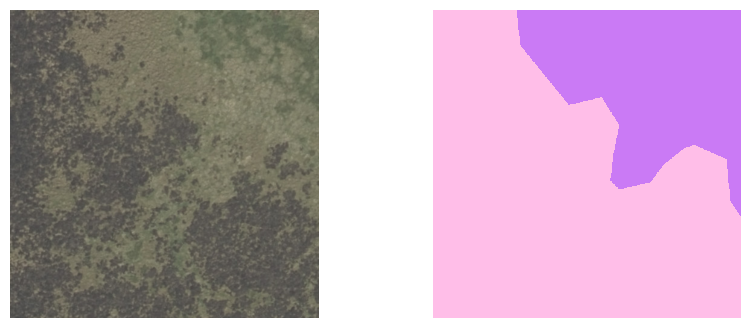

In [51]:
path_mapping_dict_id = '../content/label_mapping_dicts/label_mapping_dict__identity__2023-04-20-1541.pkl'
with open(path_mapping_dict_id, 'rb') as f:
    label_mapping_dict_identity = pickle.load(f)
    
## Load tiff:
import tifffile
path_tiff = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_all_tiles/tiff_train/SK0790_patch060.tif'
tiff_ex = tifffile.imread(path_tiff)
print(tiff_ex.shape)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
lcv.plot_image_simple(im=tiff_ex[0:3, :, :], ax=ax[0])
lcv.plot_landcover_image(im=tiff_ex[3, :, :], ax=ax[1], lc_class_name_list=list(label_mapping_dict_identity['dict_new_names'].values()),
                         unique_labels_array=list(label_mapping_dict_identity['dict_new_names'].keys()),
                         plot_colorbar=False)

In [17]:
path_save

'/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_all_tiles/tiff_train/SE0503_patch000.tif'

# TMP: testing dissolving

In [49]:
# path_nondis_tile = '/home/tplas/predictions/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/merged_predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/merged_predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override.shp'
# path_nondis_tile = '/home/tplas/predictions/predictions_LCU_2023-04-21-1335_notdissolved_clippedC_padding44/merged_predictions_LCU_2023-04-21-1335_notdissolved_clippedC_padding44/merged_predictions_LCU_2023-04-21-1335_notdissolved_clippedC_padding44.shp'
# path_nondis_tile = '/home/tplas/predictions/testing_grounds/predictions_LCU_2023-04-24-1259_dissolved-th-combi-11_padding44_FGH-override/merged_predictions_LCU_2023-04-24-1259_dissolved-th-combi-11_padding44_FGH-override/merged_predictions_LCU_2023-04-24-1259_dissolved-th-combi-11_padding44_FGH-override.shp'
# path_nondis_tile = '/home/tplas/predictions/testing_grounds/predictions_LCU_2023-04-25-2057_dissolved-th-combi-11_clippedD_padding44/merged_predictions_LCU_2023-04-25-2057_dissolved-th-combi-11_clippedD_padding44/merged_predictions_LCU_2023-04-25-2057_dissolved-th-combi-11_clippedD_padding44.shp'
path_nondis_tile = '/home/tplas/predictions/testing_grounds/predictions_LCU_2023-04-25-2057_dissolved-th-combi-1_clippedD_padding44/merged_predictions_LCU_2023-04-25-2057_dissolved-th-combi-1_clippedD_padding44/merged_predictions_LCU_2023-04-25-2057_dissolved-th-combi-1_clippedD_padding44.shp'
gdf_pols = lca.load_pols(path_nondis_tile)

In [45]:
tmp_cl_names = gdf_pols['Class name'].unique()


In [46]:
for cl_name in tmp_cl_names:
    print(cl_name, f'Number of polygons: {len(gdf_pols[gdf_pols["Class name"] == cl_name])}. Min area: {gdf_pols[gdf_pols["Class name"] == cl_name]["geometry"].area.min()}. Max area: {gdf_pols[gdf_pols["Class name"] == cl_name]["geometry"].area.max()}')

NO CLASS Number of polygons: 188. Min area: 0.015625. Max area: 970441.09375
Upland Heath Number of polygons: 1174. Min area: 0.015625. Max area: 690702.625
Blanket Peat Grass Moor Number of polygons: 1398. Min area: 0.015625. Max area: 13767.90625
Bracken Number of polygons: 2037. Min area: 0.015625. Max area: 31705.0
Upland Heath/Blanket Peat Mosaic Number of polygons: 675. Min area: 0.015625. Max area: 12569.015625
Wetland, Peat Bog Number of polygons: 1069. Min area: 0.015625. Max area: 590.53125
Wetland, Wet Grassland and Rush Pasture Number of polygons: 1458. Min area: 0.015625. Max area: 4620.671875


In [50]:
for cl_name in tmp_cl_names:
    print(cl_name, f'Number of polygons: {len(gdf_pols[gdf_pols["Class name"] == cl_name])}. Min area: {gdf_pols[gdf_pols["Class name"] == cl_name]["geometry"].area.min()}. Max area: {gdf_pols[gdf_pols["Class name"] == cl_name]["geometry"].area.max()}')

NO CLASS Number of polygons: 40. Min area: 12.1875. Max area: 974514.234375
Upland Heath Number of polygons: 99. Min area: 10.171875. Max area: 719834.015625
Blanket Peat Grass Moor Number of polygons: 152. Min area: 10.515625. Max area: 14135.0
Bracken Number of polygons: 301. Min area: 10.015625. Max area: 32230.578125
Upland Heath/Blanket Peat Mosaic Number of polygons: 1. Min area: 12569.015625. Max area: 12569.015625
Wetland, Peat Bog Number of polygons: 0. Min area: nan. Max area: nan
Wetland, Wet Grassland and Rush Pasture Number of polygons: 5. Min area: 1325.5625. Max area: 4647.046875


In [33]:
gdf_pols

,class,Class name,lc_label,area,polygon_id,source,geometry
0,0.0,NO CLASS,0,68.656250,0,model prediction,"POLYGON ((421656.875 396002.375, 421656.875 39..."
1,0.0,NO CLASS,0,20.546875,1,model prediction,"POLYGON ((421655.000 396009.000, 421654.875 39..."
2,0.0,NO CLASS,0,26.250000,2,model prediction,"POLYGON ((421105.625 396009.000, 421105.625 39..."
3,0.0,NO CLASS,0,11.406250,3,model prediction,"POLYGON ((421632.500 396027.375, 421632.375 39..."
4,0.0,NO CLASS,0,36.062500,4,model prediction,"POLYGON ((421619.875 396037.750, 421619.875 39..."
...,...,...,...,...,...,...,...
7994,6.0,"Wetland, Wet Grassland and Rush Pasture",F3d,24.609375,142,model prediction,"POLYGON ((404852.375 364938.250, 404852.500 36..."
7995,6.0,"Wetland, Wet Grassland and Rush Pasture",F3d,29.437500,143,model prediction,"POLYGON ((404894.375 364988.375, 404894.375 36..."
7996,6.0,"Wetland, Wet Grassland and Rush Pasture",F3d,11.562500,144,model prediction,"POLYGON ((404884.750 364985.375, 404885.000 36..."
7997,6.0,"Wetland, Wet Grassland and Rush Pasture",F3d,210.031250,145,model prediction,"POLYGON ((404895.500 364990.625, 404895.250 36..."


In [7]:
LCU = lcm.load_model(filename='LCU_2023-04-24-1259.data')

Loaded LCU_2023-04-24-1259
loss_function is cross_entropy
n_max_epochs is 60
LandCoverUNet class using CrossEntropyLoss()
main_categories_F3inDE_noFGH training using randomly split eval patch data. cross_entropy resnet50 60 epochs


In [8]:
LCU.dict_training_details.keys()

dict_keys(['df_patches', 'im_dir', 'mask_dir', 'path_mapping_dict', 'preprocessing_func', 'rgb_means', 'rgb_std', 'shuffle_order_patches', 'frac_subsample', 'unique_labels_arr', 'mapping_label_to_new_dict', 'class_name_list', 'n_classes', 'list_tile_names', 'batch_size', 'n_cpus', 'n_max_epochs', 'learning_rate', 'use_valid_ds', 'loss_function', 'tile_patch_train_test_split_dict_path', 'duration_training'])

In [10]:
LCU.dict_training_details['mapping_label_to_new_dict']

{0: 0,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 2,
 9: 2,
 10: 2,
 11: 2,
 12: 2,
 13: 2,
 14: 2,
 15: 2,
 16: 2,
 17: 2,
 18: 2,
 19: 2,
 20: 2,
 21: 3,
 22: 3,
 23: 3,
 24: 0,
 25: 0,
 26: 2,
 27: 0,
 28: 0,
 29: 3,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0}

# TMP: override FGH on main pred

In [30]:
# path_ex_tile = '/home/tplas/predictions/predictions_LCU_2023-04-24-1259_notdissolved_padding44/LCU_2023-04-24-1259_SK2196_LC-prediction/LCU_2023-04-24-1259_SK2196_LC-prediction.shp'
tn = 'SK1661'
path_ex_tile = f'/home/tplas/predictions/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/LCU_2023-04-24-1259_{tn}_LC-prediction_FGH-override/LCU_2023-04-24-1259_{tn}_LC-prediction_FGH-override.shp'

gpd_ex_tile = lca.load_pols(path_ex_tile)
gpd_ex_tile

,lc_label,source,class,geometry
0,C,model prediction,1,"POLYGON ((416119.625 361405.625, 416119.125 36..."
1,C,model prediction,1,"POLYGON ((416219.250 361544.250, 416219.250 36..."
2,C,model prediction,1,"POLYGON ((416099.500 361512.750, 416099.500 36..."
3,C,model prediction,1,"POLYGON ((416072.625 361539.625, 416072.625 36..."
4,C,model prediction,1,"POLYGON ((416218.750 361546.125, 416218.750 36..."
...,...,...,...,...
250,H3b,OS NGD retrieved 2023-01-10,6,"POLYGON ((416230.701 361541.500, 416230.625 36..."
251,H3b,OS NGD retrieved 2023-01-10,6,"POLYGON ((416170.815 361572.212, 416174.056 36..."
252,H3b,OS NGD retrieved 2023-01-10,6,"POLYGON ((416177.942 361577.025, 416181.556 36..."
253,H3b,OS NGD retrieved 2023-01-10,6,"POLYGON ((416273.375 361415.574, 416275.013 36..."


In [8]:
[x for x in gpd_ex_tile.columns if x not in ['Class name', 'geometry']]

['class']

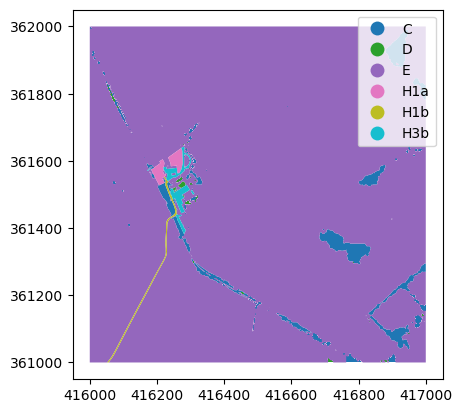

In [32]:
gpd_ex_tile.plot(column='lc_label', legend=True)


## Tmp: merge predictions pols to create rasters
- Load separate shp files in gpd 
- Merge (are non-overlapping), get rid of no-class
- Get tile outlines of interest
- Create vectors per tile 
- Create raster 
- Export

In [3]:
paths_pred = {
    'C': '/home/tplas/predictions/predictions_LCU_2023-04-21-1335_dissolved20m2_clipped1_padding44/merged_tiles_predictions_LCU_2023-04-21-1335_dissolved20m2_clipped1_padding44/merged_tiles_predictions_LCU_2023-04-21-1335_dissolved20m2_clipped1_padding44.shp',
    'D': '/home/tplas/predictions/predictions_LCU_2023-04-25-2057_dissolved100m2_clipped2_padding44/merged_tiles_predictions_LCU_2023-04-25-2057_dissolved100m2_clipped2_padding44/merged_tiles_predictions_LCU_2023-04-25-2057_dissolved100m2_clipped2_padding44.shp',
    'E': '/home/tplas/predictions/predictions_LCU_2023-04-24-1216_dissolved100m2_clipped3_padding44/merged_tiles_predictions_LCU_2023-04-24-1216_dissolved100m2_clipped3_padding44/merged_tiles_predictions_LCU_2023-04-24-1216_dissolved100m2_clipped3_padding44.shp'
}

gpd_pred = {key: gpd.read_file(paths_pred[key]) for key in paths_pred.keys()}
for key, val in gpd_pred.items():
    gpd_pred[key] = val[val['Class name'] != 'NO CLASS']

In [4]:
path_mapping = '../content/label_mapping_dicts/label_mapping_dict__all_relevant_subclasses__2023-04-20-1540.pkl'
with open(path_mapping, 'rb') as f:
    dict_mapping = pickle.load(f)

dict_mapping['dict_new_names']

{0: 'NO CLASS',
 1: 'Broadleaved High Forest',
 2: 'Coniferous High Forest',
 3: 'Scrub',
 4: 'Clear Felled/New Plantings in Forest Areas',
 5: 'Upland Heath',
 6: 'Blanket Peat Grass Moor',
 7: 'Bracken',
 8: 'Upland Heath/Blanket Peat Mosaic',
 9: 'Cultivated Land',
 10: 'Improved Pasture',
 11: 'Rough Pasture',
 12: 'Wetland, Peat Bog',
 13: 'Wetland, Wet Grassland and Rush Pasture'}

In [12]:
df_schema = lca.create_df_mapping_labels_2022_to_80s()
df_schema

adding scrub
splitting up heath
adding wetland
adding transport


,description_2022,description_80s,code_80s,code_2022,index_2022,index_80s
0,NO CLASS,NO CLASS,0,0,0,0
1,Broadleaved High Forest,Broadleaved High Forest,C1,C1,1,1
2,Coniferous High Forest,Coniferous High Forest,C2,C2,2,2
3,Mixed High Forest,Mixed High Forest,C3,C3,3,3
4,Scrub,Scrub,C4,C4a,4,4
5,Scrub Pasture,Scrub,C4,C4b,5,4
6,Woodland/Scrub Edge,Scrub,C4,C4c,6,4
7,Clear Felled/New Plantings in Forest Areas,Clear Felled/New Plantings in Forest Areas,C5,C5,7,5
8,Upland Heath,Upland Heath,D1,D1a,8,6
9,Upland Heath Blanket Bog,Upland Heath,D1,D1b,9,6


In [6]:
gpd_pred_merged = gpd.GeoDataFrame(pd.concat([gpd_pred['C'], gpd_pred['D'], gpd_pred['E']], ignore_index=True))
gpd_pred_merged = gpd_pred_merged.reset_index(drop=True)

unique_class_names = gpd_pred_merged['Class name'].unique()
## assert all class naems are in dict_mapping
for class_name in unique_class_names:
    assert class_name in df_schema['description_2022'].unique() 

## override class label because gpd hav ebeen merged
# dict_name_to_label = {val: key for key, val in dict_mapping['dict_new_names'].items()}
dict_name_to_label = {df_schema['description_2022'].iloc[x]: df_schema['index_2022'].iloc[x] for x in range(len(df_schema))}
gpd_pred_merged['class'] = gpd_pred_merged['Class name'].map(dict_name_to_label)
gpd_pred_merged

,class,Class name,area,polygon_id,geometry
0,1,Broadleaved High Forest,1052.078125,45.0,"POLYGON ((409063.250 356087.500, 409063.125 35..."
1,1,Broadleaved High Forest,167.812500,46.0,"POLYGON ((409091.625 356107.125, 409091.500 35..."
2,1,Broadleaved High Forest,881.812500,47.0,"POLYGON ((409015.000 356127.250, 409015.000 35..."
3,1,Broadleaved High Forest,712.609375,48.0,"POLYGON ((409085.500 356139.250, 409085.375 35..."
4,1,Broadleaved High Forest,86.828125,49.0,"POLYGON ((409064.000 356165.125, 409064.000 35..."
...,...,...,...,...,...
26998,29,"Wetland, Wet Grassland and Rush Pasture",101.953125,106.0,"POLYGON ((400567.625 375477.250, 400568.125 37..."
26999,29,"Wetland, Wet Grassland and Rush Pasture",118.671875,107.0,"POLYGON ((400771.125 375513.375, 400771.250 37..."
27000,29,"Wetland, Wet Grassland and Rush Pasture",160.453125,108.0,"POLYGON ((400872.375 375534.250, 400872.375 37..."
27001,29,"Wetland, Wet Grassland and Rush Pasture",177.171875,109.0,"POLYGON ((400806.375 375622.375, 400806.500 37..."


In [13]:
fgh_layer = lca.load_pols('/home/tplas/data/gis/tmp_fgh_layer/tmp_fgh_layer.shp')
dict_code_to_label = {df_schema['code_2022'].iloc[x]: df_schema['index_2022'].iloc[x] for x in range(len(df_schema))}
dict_code_to_label['G2'] = dict_code_to_label['G2a']
for lab in fgh_layer['lc_label'].unique():
    assert lab in dict_code_to_label.keys(), lab
fgh_layer['class'] = fgh_layer['lc_label'].map(dict_code_to_label)

In [25]:
df_tile_outlines = lca.load_pols('../content/landscape_character_grid/Landscape_Character_Grid.shp')
tiles_interest = ['SK0961', 'SK2096', 'SK0987', 'SK1091']
df_tile_outlines = df_tile_outlines[df_tile_outlines['PLAN_NO'].isin(tiles_interest)]

dict_pols_per_tile = {} 
dict_rasters_per_tile = {}
dict_fgh_rasters_per_tile = {}

for tile in tqdm(tiles_interest):
    pol_outline = df_tile_outlines[df_tile_outlines['PLAN_NO'] == tile]
    pol_outline = pol_outline['geometry'].iloc[0]

    ## get all polygons that intersect with tile
    pols_intersect = gpd_pred_merged[gpd_pred_merged.intersects(pol_outline)]
    dict_pols_per_tile[tile] = pols_intersect

    fgh_pols = fgh_layer[fgh_layer.intersects(pol_outline)]
    n_pols = len(fgh_pols)
    new_pols = [] 
    new_classes = []
    for nn in range(n_pols):
        pol = fgh_pols.iloc[nn]['geometry']
        pol_intersect_tile = pol.intersection(pol_outline)
        new_pols.append(pol_intersect_tile)
        new_classes.append(fgh_pols.iloc[nn]['class'])

    fgh_pols = gpd.GeoDataFrame(geometry=new_pols)
    fgh_pols['class'] = new_classes

    fgh_pols = fgh_pols.explode().reset_index(drop=True)
    # fgh_pols
    # assert False
    pols_diff = gpd.overlay(pols_intersect, fgh_pols, how='difference')
    # assert False
    pols_intersect = gpd.overlay(pols_intersect, fgh_pols, how='intersection')
    pols_intersect['class'] = pols_intersect['class_2']
    pols_intersect = pols_intersect.drop(columns=['class_1', 'class_2'])
    pols_intersect = pd.concat([pols_intersect, pols_diff], ignore_index=True)

    dict_rasters_per_tile[tile] = lca.convert_shp_mask_to_raster(df_shp=pols_intersect, col_name='class')

    # dict_fgh_rasters_per_tile[tile] = lca.convert_shp_mask_to_raster(df_shp=fgh_pols, col_name='class')

 50%|█████     | 2/4 [00:20<00:19,  9.65s/it]/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
 75%|███████▌  | 3/4 [00:27<00:08,  8.24s/it]/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/home/tplas/anaconda3/envs/geo/lib/pytho

In [33]:

for tile in tqdm(tiles_interest):
    dict_rasters_per_tile[tile].rio.to_raster(f'/home/tplas/predictions/raster_lc_predictions_dsg/{tile}_lc_predictions.tif')

100%|██████████| 4/4 [00:00<00:00,  8.17it/s]


In [32]:
import json
dict_label_to_name = {int(val): key for key, val in dict_name_to_label.items()}
with open('/home/tplas/predictions/raster_lc_predictions_dsg/lc_schema_predictions.json', 'w') as fp:
    json.dump(dict_label_to_name, fp)

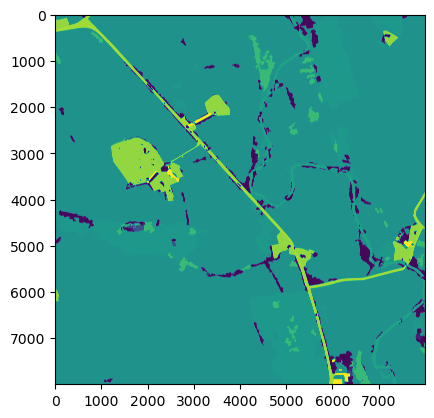

In [26]:
plt.imshow(dict_rasters_per_tile['SK0961']['class'])

## Break: make rush pasture habitat selection

In [4]:
df_tile_outlines = lca.load_pols('../content/rush_tiles/rush_primaryhabitat_tiles.shp')
tile_name_col = 'PLAN_NO'
list_tile_names_to_predict = df_tile_outlines[tile_name_col].unique().tolist()
# list_tile_names_to_predict

In [40]:
path_full_hab_layer = '/home/tplas/data/gis/Habitat_Networks_(England)_-_Purple_Moor_Grass_&_Rush_Pasture/Habitat_Networks_(England)_-_Purple_Moor_Grass_&_Rush_Pasture.shp'
pd_outline = lca.load_pols(path_dict['pd_outline'])
df_tile_outlines = lca.load_pols(path_dict['landscape_character_grid_path'])
df_hab_rush_full = lca.load_pols(path_full_hab_layer)

In [41]:
## Find all polygons that are within the PD outline:
df_hab_rush = df_hab_rush_full[df_hab_rush_full.within(pd_outline.unary_union)]
df_hab_rush = df_hab_rush.reset_index(drop=True)

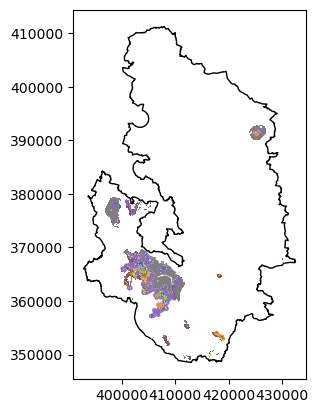

In [42]:
ax = plt.subplot(111)
pd_outline.plot(ax=ax, facecolor='none', edgecolor='black')
df_hab_rush.plot(ax=ax, column='Class', facecolor='blue', edgecolor='none')


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  


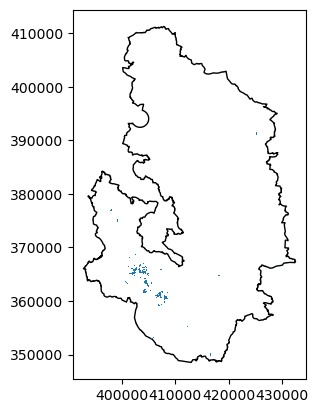

In [43]:
df_hab_rush = df_hab_rush[df_hab_rush['Class'] == 'Primary Habitat']
df_hab_rush = df_hab_rush.explode().reset_index(drop=True)

ax = plt.subplot(111)
pd_outline.plot(ax=ax, facecolor='none', edgecolor='black')
df_hab_rush.plot(ax=ax, column='Class', facecolor='blue', edgecolor='none')
# df_hab_rush

In [44]:
## Find tiles that intersect with the habitat polygons:
df_tile_outlines['intersect'] = df_tile_outlines.intersects(df_hab_rush.unary_union)
df_tile_outlines = df_tile_outlines[df_tile_outlines['intersect'] == True]

In [45]:
len(df_tile_outlines)

64

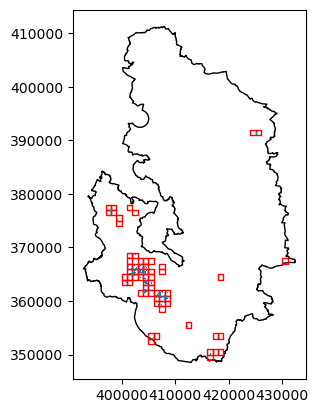

In [46]:
ax = plt.subplot(111)
pd_outline.plot(ax=ax, facecolor='none', edgecolor='black')
df_tile_outlines.plot(ax=ax, facecolor='none', edgecolor='red')
df_hab_rush.plot(ax=ax, column='Class', facecolor='blue', edgecolor='none')

In [47]:
df_tile_outlines = df_tile_outlines.reset_index(drop=True)
df_tile_outlines.to_file('../content/rush_tiles/rush_primaryhabitat_tiles.shp')

In [49]:
# df_tile_outlines

## Continue:

In [8]:
path_label_map_list = os.listdir('../content/label_mapping_dicts/')
path_label_map_list.sort()
# print(path_label_map_list)
path_label_map = os.path.join('../content/label_mapping_dicts/', path_label_map_list[2])
print(path_label_map)
# path_label_map = '../content/label_mapping_dicts/label_mapping_dict__main_categories_F3inDE_noFGH__2023-04-21-1315.pkl'
dict_mapping = pickle.load(open(path_label_map, 'rb'))

dict_mapping['dict_new_names']

../content/label_mapping_dicts/label_mapping_dict__E_subclasses_and_F3d_only__2023-04-20-1541.pkl


{0: 'NO CLASS',
 1: 'Cultivated Land',
 2: 'Improved Pasture',
 3: 'Rough Pasture',
 4: 'Wetland, Wet Grassland and Rush Pasture'}

In [56]:
# lca.create_new_label_mapping_dict(mapping_type='main_categories_F3inDE_noFGH', save_mapping=False)
tmp = lca.create_df_mapping_labels_2022_to_80s()
# tmp

adding scrub
splitting up heath
adding wetland
adding transport


In [7]:
dict_mapping = lca.create_new_label_mapping_dict(mapping_type='main_categories_F3inDE_noFGH', save_mapping=True)
print(dict_mapping.keys())

adding scrub
splitting up heath
adding wetland
adding transport
Saved mapping dict to /home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/label_mapping_dict__main_categories_F3inDE_noFGH__2023-04-21-1315.pkl
dict_keys(['dict_label_mapping', 'dict_name_mapping', 'dict_old_names', 'dict_new_names'])


In [3]:
eval_patch_outlines = lca.load_pols('../content/evaluation_sample_50tiles/eval_patch_grid_annotations/eval_patch_grid_annotations.shp')
eval_patch_outlines_2 = lca.load_pols('../content/evaluation_sample_50tiles/eval_2_patch_grid_annotations/eval_2_patch_grid_annotations.shp')

In [4]:
eval_patch_concat = pd.concat((eval_patch_outlines, eval_patch_outlines_2), axis=0)

In [5]:
eval_patch_concat = eval_patch_concat[np.logical_or(eval_patch_concat['RAND_ANNOT'] == 1, 
                                                    eval_patch_concat['SEL_ANNOT'] == 1)]
print(len(eval_patch_concat), ' patches selected')
eval_patch_concat = eval_patch_concat.reset_index(drop=True)
eval_patch_concat

1028  patches selected


,RAND_ANNOT,SEL_ANNOT,Class_low,tile_i,tile_patch,patch_i,geometry
0,1,0,0,SE0503,SE0503_p0,0,"POLYGON ((405064.003 403999.995, 405064.003 40..."
1,1,0,0,SE0503,SE0503_p211,211,"POLYGON ((405128.003 403103.995, 405128.003 40..."
2,1,0,0,SE0503,SE0503_p123,123,"POLYGON ((405256.003 403487.995, 405256.003 40..."
3,1,0,0,SE0503,SE0503_p95,95,"POLYGON ((405384.003 403615.995, 405384.003 40..."
4,1,0,0,SE0503,SE0503_p51,51,"POLYGON ((405448.003 403807.995, 405448.003 40..."
...,...,...,...,...,...,...,...
1023,0,1,0,SK2677,SK2677_p69,69,"POLYGON ((426640.000 377743.998, 426640.000 37..."
1024,0,1,0,SK2677,SK2677_p115,115,"POLYGON ((426704.000 377551.998, 426704.000 37..."
1025,0,1,0,SK2677,SK2677_p173,173,"POLYGON ((426576.000 377295.998, 426576.000 37..."
1026,0,1,0,SK2677,SK2677_p174,174,"POLYGON ((426640.000 377295.998, 426640.000 37..."


In [66]:
# eval_patch_concat = eval_patch_concat.reset_index(drop=True)
# eval_patch_concat['tile_patch'] = eval_patch_concat['tile_patch'].apply(lambda x: x[:8] + x[8:].zfill(3))
# eval_patch_concat.to_file('../content/evaluation_sample_50tiles/eval_all_patch_grid/eval_all_patch_grid.shp')

In [12]:
eval_patch_concat = eval_patch_concat.reset_index(drop=True)
eval_patch_concat['tile_patch'] = eval_patch_concat['tile_patch'].apply(lambda x: x[:8] + x[8:].zfill(3))
## split into random 70/30 sample:
# tmp_inds = np.random.choice([0,1], size=len(eval_patch_concat), p=[0.7, 0.3])
# tmp_inds = copy.deepcopy(tmp_inds)
n_ones = int(0.3 * len(eval_patch_concat))
tmp_inds = np.zeros(len(eval_patch_concat))
tmp_inds[:n_ones] = 1
np.random.shuffle(tmp_inds)
dict_train_test_split = {'train': list(eval_patch_concat[tmp_inds == 0]['tile_patch'].values), 
                         'test': list(eval_patch_concat[tmp_inds == 1]['tile_patch'].values)}
for key in ['train', 'test']:
    dict_train_test_split[key] = [x.replace('p', 'patch') for x in dict_train_test_split[key]]
## assert that all patches are in either train or test:
assert len(eval_patch_concat) == len(dict_train_test_split['train']) + len(dict_train_test_split['test'])
## assert no overlap between train and test:
assert len(set(dict_train_test_split['train']).intersection(set(dict_train_test_split['test']))) == 0, f'Overlap: {set(dict_train_test_split["train"]).intersection(set(dict_train_test_split["test"]))}'

## save train/test split as pkl:
ts = lca.create_timestamp()
with open(f'../content/evaluation_sample_50tiles/train_test_split_80tiles_{ts}.pkl', 'wb') as f:
    pickle.dump(dict_train_test_split, f)

In [14]:
# eval_patch_outlines = lca.load_pols('../content/evaluation_sample_50tiles/eval_patch_grid_annotations/eval_patch_grid_annotations.shp')
eval_patch_outlines = lca.load_pols('../content/evaluation_sample_50tiles/eval_2_patch_grid_annotations/eval_2_patch_grid_annotations.shp')
eval_patch_outlines = eval_patch_outlines[np.logical_or(eval_patch_outlines['RAND_ANNOT'] == 1, 
                                                        eval_patch_outlines['SEL_ANNOT'] == 1)]
eval_patch_outlines

,RAND_ANNOT,SEL_ANNOT,Class_low,patch_i,tile_i,tile_patch,geometry
59,0,1,0,59,SE0407,SE0407_p59,"POLYGON ((404960.001 407808.000, 404960.001 40..."
61,0,1,0,61,SE0407,SE0407_p61,"POLYGON ((404128.001 407744.000, 404128.001 40..."
62,0,1,0,62,SE0407,SE0407_p62,"POLYGON ((404192.001 407744.000, 404192.001 40..."
77,0,1,0,77,SE0407,SE0407_p77,"POLYGON ((404192.001 407680.000, 404192.001 40..."
163,0,1,0,163,SE0407,SE0407_p163,"POLYGON ((404896.001 407360.000, 404896.001 40..."
...,...,...,...,...,...,...,...
6594,0,1,0,69,SK2677,SK2677_p69,"POLYGON ((426640.000 377743.998, 426640.000 37..."
6640,0,1,0,115,SK2677,SK2677_p115,"POLYGON ((426704.000 377551.998, 426704.000 37..."
6698,0,1,0,173,SK2677,SK2677_p173,"POLYGON ((426576.000 377295.998, 426576.000 37..."
6699,0,1,0,174,SK2677,SK2677_p174,"POLYGON ((426640.000 377295.998, 426640.000 37..."


In [6]:
create_patches_from_polygons_data.main(
    path_image_tile_tifs = '/media/data-hdd/gis_pd/all_pd_tiles/',
        path_tile_outline_shp = '/home/tplas/repos/cnn-land-cover/content/evaluation_sample_50tiles/eval_all_tile_outlines/eval_all_tile_outlines.shp',
        save_dir_mask_tifs = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_all_tiles/tile_masks_detailed_annotation/',
        path_lc = '/home/tplas/repos/cnn-land-cover/content/evaluation_polygons/landscape_character_2022_detailed_CFGH-override/landscape_character_2022_detailed_CFGH-override.shp',
        df_lc=None,
        dir_im_save_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_all_tiles/images_detailed_annotation/',  # where to save patches 
        dir_mask_save_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_all_tiles/masks_detailed_annotation/',
        create_patches = True,
        create_mask_tiles = True,
        save_im_patches = True,
        tif_ims_in_subdirs = True,  # True if tif images are in subdirectories of path_image_tile_tifs
        create_metadata_patches = True,
        discard_empty_patches = True, # whether to discard patches that do not contain any landcover class (ie only NO CLASS)
        suffix_name = '_lc_2022_detailed_mask',
        col_name_class_index = None,  # if None, will be created
        col_name_class_name = 'Class_low',
        create_high_level_masks = False,
        df_sel_tile_patch_name_col='tile_patch',
        df_patches_selected=eval_patch_concat)


Loaded landcover polygons:

adding scrub
splitting up heath
adding wetland
adding transport
Classes not mapped: ['C' 'H']

Creating and exporting tif masks:


100%|██████████| 80/80 [00:03<00:00, 22.11it/s]


0 tiles were empty: []


 60%|██████    | 48/80 [02:40<01:43,  3.23s/it]

 71%|███████▏  | 57/80 [03:09<01:14,  3.23s/it]

100%|██████████| 80/80 [04:26<00:00,  3.33s/it]



Creating and exporting patches:
Found 1617 images and 80 masks
['/media/data-hdd/gis_pd/all_pd_tiles/117967-1_RGB_229_Shape/SJ9762.tif', '/media/data-hdd/gis_pd/all_pd_tiles/117967-1_RGB_203_Shape/SJ9661.tif', '/media/data-hdd/gis_pd/all_pd_tiles/117974-1_RGB_308_Shape/SK2194.tif', '/media/data-hdd/gis_pd/all_pd_tiles/117967-1_RGB_315_Shape/SK0079.tif']
Creating patches from 1617 images and 80 masks
First few: ['/media/data-hdd/gis_pd/all_pd_tiles/117967-1_RGB_229_Shape/SJ9762.tif', '/media/data-hdd/gis_pd/all_pd_tiles/117967-1_RGB_203_Shape/SJ9661.tif', '/media/data-hdd/gis_pd/all_pd_tiles/117974-1_RGB_308_Shape/SK2194.tif'] and ['/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_all_tiles/tile_masks_detailed_annotation/SK1896_lc_2022_detailed_mask.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_all_tiles/tile_masks_detailed_annotation/SK0956_lc_2022_detailed_mask.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_all_tiles/tile_masks_detailed_anno

848it [00:35, 50.22it/s] 

Patch (137, 'SK1588_p137') is empty, not saving


1617it [00:45, 35.74it/s] 


In [4]:
eval_patch_outlines = lca.load_pols('../content/evaluation_sample_50tiles/eval_patch_grid_annotations/eval_patch_grid_annotations.shp')
eval_patch_outlines = eval_patch_outlines[np.logical_or(eval_patch_outlines['RAND_ANNOT'] == 1, 
                                                        eval_patch_outlines['SEL_ANNOT'] == 1)]

create_patches_from_polygons_data.main(
    path_image_tile_tifs = '/media/data-hdd/gis_pd/all_pd_tiles/',
        path_tile_outline_shp = '/home/tplas/repos/cnn-land-cover/content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp',
        save_dir_mask_tifs = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_detailed_annotation/',
        path_lc = '/home/tplas/repos/cnn-land-cover/content/evaluation_polygons/landscape_character_2022_detailed_CFGH-override/landscape_character_2022_detailed_CFGH-override.shp',
        df_lc=None,
        description_df_lc_for_metadata=None,
        dir_im_save_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/images_detailed_annotation/',  # where to save patches 
        dir_mask_save_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/masks_detailed_annotation/',
        create_patches = True,
        create_mask_tiles = True,
        save_im_patches = True,
        tif_ims_in_subdirs = True,  # True if tif images are in subdirectories of path_image_tile_tifs
        create_metadata_patches = True,
        discard_empty_patches = True, # whether to discard patches that do not contain any landcover class (ie only NO CLASS)
        suffix_name = '_lc_2022_detailed_mask',
        col_name_class_index = None,  # if None, will be created
        col_name_class_name = 'Class_low',
        create_high_level_masks = False,
        df_sel_tile_patch_name_col='tile_patch',
        df_patches_selected=eval_patch_outlines)

Geometry Ring Self-intersection[405166.645500001 354069.537799999] for inds [3448]
Attempting to make valid
Done
Geometry Ring Self-intersection[407379.638966848 352904.669116294] for inds [465]
Attempting to make valid
Done
Geometry Ring Self-intersection[407495.557080073 405488.00284208] for inds [1722]
Attempting to make valid
Done
Geometry Ring Self-intersection[407588.8603 352489.939199999] for inds [1316]
Attempting to make valid
Done
Geometry Ring Self-intersection[407597.556900001 352132.544300001] for inds [482]
Attempting to make valid
Done
Geometry Ring Self-intersection[408576.001399294 352149.6823] for inds [4273]
Attempting to make valid
Done
Geometry Ring Self-intersection[414871.025378596 372829.307805445] for inds [2296]
Attempting to make valid
Done
Geometry Ring Self-intersection[415825.015405168 368957.661992135] for inds [1533]
Attempting to make valid
Done
Geometry Ring Self-intersection[421050.500000001 396097.5] for inds [2423]
Attempting to make valid
Done
Geom

100%|██████████| 50/50 [00:02<00:00, 19.34it/s]


0 tiles were empty: []


 96%|█████████▌| 48/50 [02:46<00:06,  3.32s/it]

100%|██████████| 50/50 [02:53<00:00,  3.47s/it]



Creating and exporting patches:
Found 1617 images and 50 masks
['/media/data-hdd/gis_pd/all_pd_tiles/117967-1_RGB_229_Shape/SJ9762.tif', '/media/data-hdd/gis_pd/all_pd_tiles/117967-1_RGB_203_Shape/SJ9661.tif', '/media/data-hdd/gis_pd/all_pd_tiles/117974-1_RGB_308_Shape/SK2194.tif', '/media/data-hdd/gis_pd/all_pd_tiles/117967-1_RGB_315_Shape/SK0079.tif']
Creating patches from 1617 images and 50 masks
First few: ['/media/data-hdd/gis_pd/all_pd_tiles/117967-1_RGB_229_Shape/SJ9762.tif', '/media/data-hdd/gis_pd/all_pd_tiles/117967-1_RGB_203_Shape/SJ9661.tif', '/media/data-hdd/gis_pd/all_pd_tiles/117974-1_RGB_308_Shape/SK2194.tif'] and ['/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_detailed_annotation/SK1896_lc_2022_detailed_mask.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_detailed_annotation/SK0790_lc_2022_detailed_mask.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eva

847it [00:30, 17.06it/s]

Patch (137, 'SK1588_p137') is empty, not saving


1617it [00:54, 29.64it/s]


In [5]:
LCU = lcm.load_model(filename='LCU_2023-03-14-1827.data')
LCU.description

Loaded LCU_2023-03-14-1827
loss_function is cross_entropy
n_max_epochs is 30
LandCoverUNet class using CrossEntropyLoss()
D class training using EVAL data. cross_entropy resnet 30 epochs


'LandCoverUNet class using CrossEntropyLoss()\nD class training using EVAL data. cross_entropy resnet 30 epochs'

In [4]:
df_eval = lca.load_pols('../content/evaluation_polygons/landscape_character_2022_detailed_CFGH-override/landscape_character_2022_detailed_CFGH-override.shp')
df_eval['area'] = df_eval['geometry'].area
df_eval.groupby('Class_low').sum()['area']

Class_low
0      4.036372e+07
C      1.497746e+05
C1     1.050174e+06
C2     5.305792e+05
C3     7.810807e+03
C4     2.262873e+04
C4a    4.379195e+04
C4b    3.320603e+03
C4c    6.037541e+03
C5     3.691567e+05
D1     2.543536e+05
D2b    1.344458e+02
D2d    2.839452e+05
D3     5.774055e+04
D6b    3.210444e+04
D6c    1.234462e+05
D7a    2.948657e+03
E2a    3.271700e+06
E2b    9.751844e+05
F      5.438268e+02
F2     2.869339e+05
F3a    1.253995e+05
F3d    1.554619e+05
G      1.021751e+03
G2     3.525916e+04
H      2.986776e+05
H1a    4.910552e+05
H1b    6.005652e+05
H2a    5.394603e+05
H3a    2.383638e+04
H3b    1.215810e+05
Name: area, dtype: float64

In [4]:
df_hab = lca.load_pols('../content/habitat_data_annotations/habitat_data_annotations.shp')
df_hab = df_hab[df_hab['SEL_TRAIN'] == 1]
df_hab.head()

,Year,UK_BAP,source,Class_low,SEL_TRAIN,area,geometry
2315,1998,Lowland Dry Acid Grassland,"Habitats - Priority, Peak District National Pa...",D2a,1,282798.652,"POLYGON ((410762.190 385648.120, 410767.003 38..."
3679,2013,"Upland Flushes, Fens & Swamps","Habitats - Priority, Peak District National Pa...",F3d,1,2286.969,"POLYGON ((396891.158 383009.654, 396901.555 38..."
3813,2013,"Upland Flushes, Fens & Swamps","Habitats - Priority, Peak District National Pa...",F3d,1,4907.303,"POLYGON ((396826.492 382989.450, 396830.533 38..."
4472,2013,Purple Moor Grass & Rush Pasture,"Habitats - Priority, Peak District National Pa...",F3d,1,46035.177,"POLYGON ((402188.973 360251.590, 402250.470 36..."
10449,1998,Purple Moor Grass & Rush Pasture,"Habitats - Priority, Peak District National Pa...",F3d,1,149451.124,"POLYGON ((426631.780 385085.273, 426637.700 38..."


In [4]:
tmp = create_patches_from_polygons_data.main(
    path_image_tile_tifs = '/media/data-hdd/gis_pd/all_pd_tiles/',
    path_tile_outline_shp = path_dict['landscape_character_grid_path'],
    save_dir_mask_tifs = '/home/tplas/data/gis/habitat_training/tile_masks_hab/',
    path_lc = None,
    df_lc=df_hab,
    description_df_lc_for_metadata='Habitat data selected from traingin 2023-03-09',
    dir_im_save_patches = '/home/tplas/data/gis/habitat_training/images/',  # where to save patches 
    dir_mask_save_patches = '/home/tplas/data/gis/habitat_training/masks_hab/',
    create_patches = True,
    save_im_patches = True,
    tif_ims_in_subdirs = True,  # True if tif images are in subdirectories of path_image_tile_tifs
    create_metadata_patches = True,
    discard_empty_patches = True, # whether to discard patches that do not contain any landcover class (ie only NO CLASS)
    suffix_name = '_lc_hab_mask',
    col_name_low_level_index = None,  # if None, will be created
    col_name_low_level_name = 'Class_low'
)

NameError: name 'df_hab' is not defined

In [28]:
train_ds = lcm.DataSetPatches(im_dir='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/images/', 
                              mask_dir='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/masks_2022_detailed/', 
                            path_mapping_dict='../content/label_mapping_dicts/label_mapping_dict__D_subclasses_only__2023-03-10-1154.pkl',
                            relabel_masks=True, shuffle_order_patches=False,
                            mask_suffix='_lc_2022_detailed.npy',
                            random_transform_data=False)

Patches sorted by tile/patch order
Loaded 497 patches
Loaded label_mapping_dict__D_subclasses_only__2023-03-10-1154.pkl to map labels


In [29]:
train_ds.remove_no_class_patches()

100%|██████████| 497/497 [00:00<00:00, 529.93it/s]

Removed 251 patches with no class


In [15]:
# train_ds.dict_mapping['dict_new_names']

Length of dataset: 246
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>


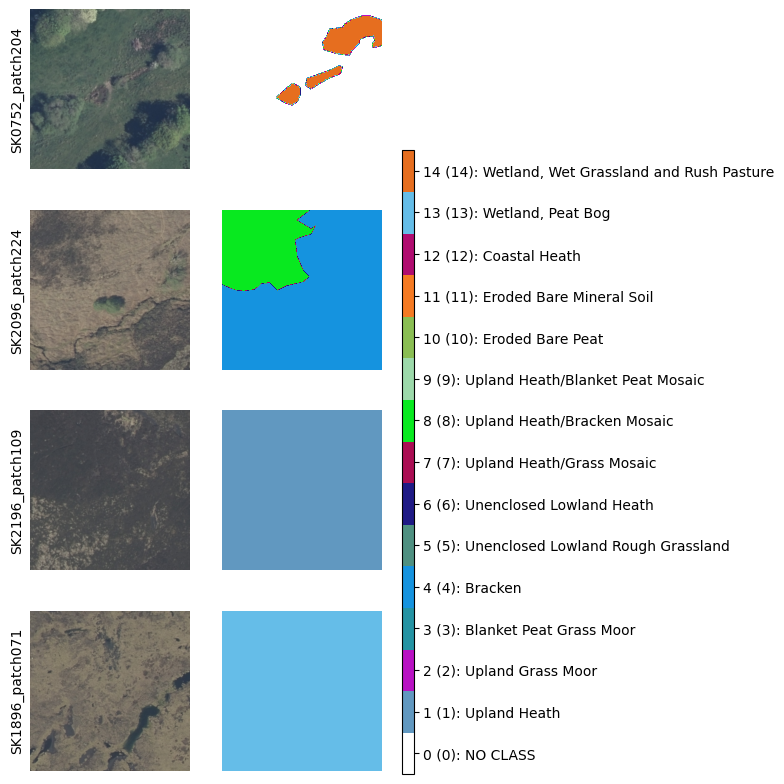

In [31]:
print(f'Length of dataset: {len(train_ds)}')

## Example patches: 
# inds_examples = [0, 1, 2, 3]
inds_examples = np.random.choice(len(train_ds), 4, replace=False)
n_ex = len(inds_examples)

## Create figure layout:
fig = plt.figure(constrained_layout=False, figsize=(4, 8))
gs_ims = fig.add_gridspec(len(inds_examples), 2, top=0.98, 
                        bottom=0.02, left=0.02, right=0.9)
gs_cbar = fig.add_gridspec(1, 1, top=0.8, bottom=0.02, 
                            left=0.95, right=0.98)
ax_cbar = fig.add_subplot(gs_cbar[0, 0])

## Plot each image & mask of patches:
for irow, idx in enumerate(inds_examples):
    ## retrieve data, mask is remapped
    im, mask = train_ds[idx] 
    patch_name = train_ds.df_patches.iloc[idx]['patch_name']

    ## Create axes:
    ax_im = fig.add_subplot(gs_ims[irow, 0])
    ax_mask = fig.add_subplot(gs_ims[irow, 1])

    ## Use land cover visualisation functions to plot:
    lcv.plot_image_simple(im=im.numpy() / 255, ax=ax_im)
    lcv.plot_landcover_image(im=mask.numpy(), ax=ax_mask, 
            lc_class_name_list=train_ds.class_name_list, 
            unique_labels_array=train_ds.unique_labels_arr,
            plot_colorbar=True if irow == n_ex - 1 else False,
            cax=ax_cbar)
    ax_im.set_ylabel(patch_name)

## Tmp fix:

In [37]:
df_main = lca.load_pols('../content/evaluation_polygons/landscape_character_2022_FGH-override/landscape_character_2022_FGH-override.shp')
df_main['Class_low'].unique()

array(['C', 'C4a', 'C1', 'E2a', 'D', 'E', 'E2b', 'F', 'F2', 'G', 'G2',
       'H', 'H1a', 'H1b', 'H2a', 'H3a', 'H3b', 'F3d'], dtype=object)

In [38]:
for un_l in df_main['Class_low'].unique():
    sub_df = df_main[df_main['Class_low'] == un_l]
    print(f'{un_l}: {len(sub_df)} polygons with labels {sub_df["Class_high"].unique()}')

C: 172 polygons with labels ['C']
C4a: 39 polygons with labels ['C']
C1: 17 polygons with labels ['C']
E2a: 22 polygons with labels ['E']
D: 68 polygons with labels ['D']
E: 258 polygons with labels ['E']
E2b: 50 polygons with labels ['E']
F: 8 polygons with labels ['F']
F2: 48 polygons with labels ['F']
G: 1 polygons with labels ['G']
G2: 18 polygons with labels ['G']
H: 554 polygons with labels ['H']
H1a: 210 polygons with labels ['H']
H1b: 84 polygons with labels ['H']
H2a: 12 polygons with labels ['H']
H3a: 3 polygons with labels ['H']
H3b: 236 polygons with labels ['H']
F3d: 29 polygons with labels ['F']


In [42]:
tmp = [np.random.randn(4, 4) for x in range(5)]
np.stack(tmp, axis=-1).shape

(4, 4, 5)

In [39]:
inds_f3d = np.where(df_main['Class_low'] == 'F3d')[0]
df_main.loc[inds_f3d, 'Class_high'] = 'E'

In [41]:
df_main.to_file('../content/evaluation_polygons/landscape_character_2022_FGH-override/landscape_character_2022_FGH-override.shp')


In [63]:
list_tiles = list(df_tile_outlines['PLAN_NO'].values)
list_tiles_train = list_tiles[::2]
list_tiles_test = [x for x in list_tiles if x not in list_tiles_train]
# list_tiles_train, list_tiles_test
import pickle 
dict_split_tiles = {'train': list_tiles_train, 'test': list_tiles_test}
with open('/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/dict_5050_traintest_split_eval_tiles.pkl', 'wb') as f:
    pickle.dump(dict_split_tiles, f)

In [3]:
df_tile_outlines = lca.load_pols('../content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')
pol_outline = df_tile_outlines[df_tile_outlines['PLAN_NO'] == 'SK1357'].iloc[0]['geometry']
eval_patch_outlines = lca.load_pols('../content/evaluation_sample_50tiles/eval_patch_grid_annotations/eval_patch_grid_annotations.shp')
eval_patch_outlines_2 = lca.load_pols('../content/evaluation_sample_50tiles/eval_2_patch_grid_annotations/eval_2_patch_grid_annotations.shp')

In [4]:
eval_patch_outlines = pd.concat([eval_patch_outlines, eval_patch_outlines_2], axis=0)

In [5]:
df_main = lca.load_pols('../content/evaluation_polygons/landscape_character_2022_FGH-override/landscape_character_2022_FGH-override.shp')
df_detailed = lca.load_pols('../content/evaluation_polygons/landscape_character_2022_detailed_CFGH-override/landscape_character_2022_detailed_CFGH-override.shp')


In [6]:
print(f'{eval_patch_outlines["SEL_ANNOT"].sum()} manually-selected patches of {len(eval_patch_outlines)} patches have been annotated')
print(f'{eval_patch_outlines["RAND_ANNOT"].sum()} randomly-selected of {len(eval_patch_outlines)} patches have been annotated')


580 manually-selected patches of 18000 patches have been annotated
448 randomly-selected of 18000 patches have been annotated


In [7]:
df_detailed = lca.test_validity_geometry_column(df_detailed)


Geometry Ring Self-intersection[405166.645500001 354069.537799999] for inds [3448]
Attempting to make valid
Done
Geometry Ring Self-intersection[407379.638966848 352904.669116294] for inds [465]
Attempting to make valid
Done
Geometry Ring Self-intersection[407495.557080073 405488.00284208] for inds [1722]
Attempting to make valid
Done
Geometry Ring Self-intersection[407588.8603 352489.939199999] for inds [1316]
Attempting to make valid
Done
Geometry Ring Self-intersection[407597.556900001 352132.544300001] for inds [482]
Attempting to make valid
Done
Geometry Ring Self-intersection[408576.001399294 352149.6823] for inds [4273]
Attempting to make valid
Done
Geometry Ring Self-intersection[414871.025378596 372829.307805445] for inds [2296]
Attempting to make valid
Done
Geometry Ring Self-intersection[415825.015405168 368957.661992135] for inds [1533]
Attempting to make valid
Done
Geometry Ring Self-intersection[421050.500000001 396097.5] for inds [2423]
Attempting to make valid
Done
Geom

In [8]:
df_detailed = df_detailed[df_detailed['Class_low'] != '0']

In [9]:
area_arr = np.argsort(df_detailed['geometry'].area.values)
# area_arr[:10]
df_detailed.iloc[area_arr[:10]]

,Class_low,source,geometry
1786,D2d,Manual annotation DA SG 2023,"POLYGON ((414338.023 400107.402, 414337.817 40..."
1720,F3d,Manual annotation DA SG 2023,"POLYGON ((407452.773 405515.503, 407453.091 40..."
3655,E2b,None,"POLYGON ((409346.100 356630.660, 409346.410 35..."
4277,E2a,Manual annotation DA SG 2023,"POLYGON ((407764.793 352259.285, 407765.848 35..."
3503,E2a,Manual annotation DA SG 2023,"POLYGON ((408389.089 352183.018, 408388.357 35..."
3504,E2a,Manual annotation DA SG 2023,"POLYGON ((408389.404 352185.232, 408389.089 35..."
3505,E2a,Manual annotation DA SG 2023,"POLYGON ((408393.683 352215.886, 408393.557 35..."
3457,C1,NFI 2020 retrieved 2023-02-15,"POLYGON ((405163.874 354050.625, 405167.805 35..."
2377,C4,Manual annotation DA SG 2023,"POLYGON ((408305.783 379837.121, 408304.340 37..."
4246,E2a,Manual annotation DA SG 2023,"POLYGON ((406697.444 365863.766, 406697.997 36..."


In [10]:
dict_pols_detailed_rand = lca.get_pols_for_tiles(df_pols=df_detailed, col_name='tile_patch',
                        df_tiles=eval_patch_outlines[np.logical_or(eval_patch_outlines['RAND_ANNOT'] == 1, eval_patch_outlines['SEL_ANNOT'] == 1)], 
                        col_ind_name='Class_low', col_class_name='Class_low')

100%|██████████| 1028/1028 [00:04<00:00, 223.35it/s]

0 tiles were empty: []


In [11]:
dict_area_0 = {}
for tp, df in dict_pols_detailed_rand.items():
    # print(f'{tp}: {len(df)}')
    if '0' in df['Class_low'].values:
        dict_area_0[tp] = df[df['Class_low'] == '0']['geometry'].area.sum()
    else:
        dict_area_0[tp] = 0

# plt.hist(dict_area_0.values(), bins=100);
np.sum(np.array(list(dict_area_0.values())) > 1)

118

Text(0, 0.5, 'Equivalent number of full patches')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


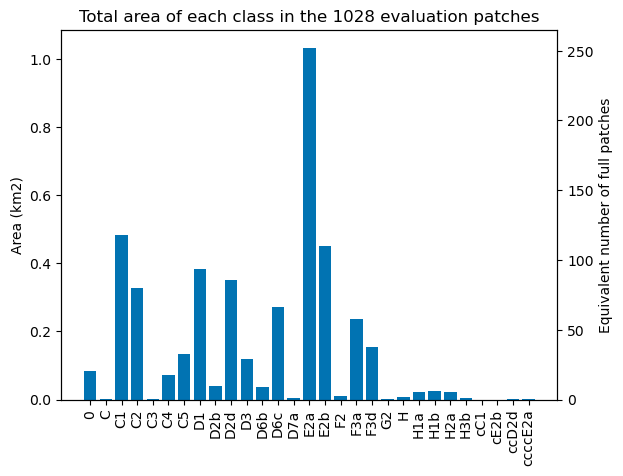

In [12]:

df_patches_only_concat = pd.concat(list(dict_pols_detailed_rand.values()))
unique_classes = df_patches_only_concat['Class_low'].unique()
dict_total_area = {}
dict_total_patches = {}
unique_classes = np.sort(unique_classes)
for c in unique_classes:
    area_m = df_patches_only_concat[df_patches_only_concat['Class_low'] == c]['geometry'].area.sum()
    dict_total_area[c] = area_m / 1e6  # convert to km2
    dict_total_patches[c] = area_m  / (64 * 64)  # convert to patches

## Bar plot of total area of each class
ax = plt.subplot(111)
ax.bar(dict_total_area.keys(), dict_total_area.values())
# ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90);
plt.xticks(rotation=90);
ax.set_ylabel('Area (km2)')
ax.set_title(f'Total area of each class in the {len(dict_pols_detailed_rand)} evaluation patches');

ax2 = ax.twinx()
ax2.bar(dict_total_area.keys(), dict_total_patches.values(), alpha=0.5)
ax2.set_ylabel('Equivalent number of full patches')

In [ ]:
pd_outline = lca.load_pols(path_dict['pd_outline'])
os_grid = lca.load_pols(path_dict['landscape_character_grid_path'])
# path_dict.keys()

In [ ]:
len(os_grid)

2125

In [ ]:
## Find all os grid polygons that intersect with pd_outline 
os_grid = os_grid[os_grid.intersects(pd_outline.iloc[0]['geometry'])]
print(len(os_grid))

1617


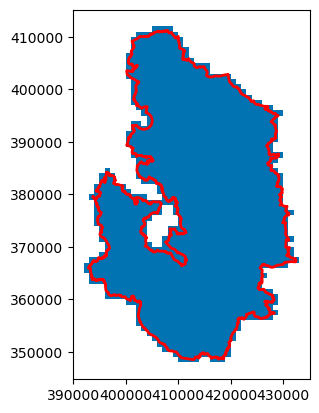

In [ ]:
ax = plt.subplot(111)


os_grid.plot(ax=ax)
pd_outline.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

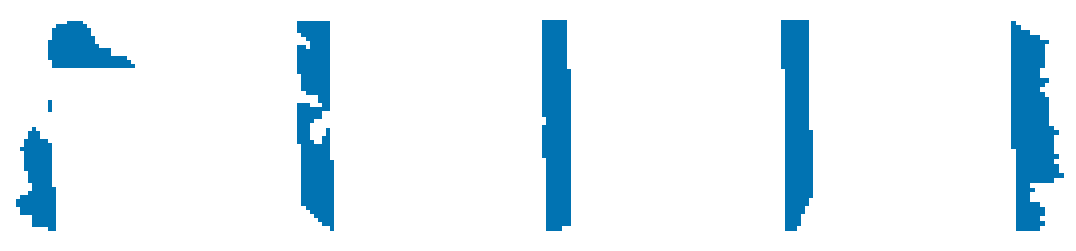

In [ ]:
# 330 * 5
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for ii in range(5):
    dir_name = f'../content/os_grid_pd/all_tiles_part_{ii}'
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    df_sub = os_grid.iloc[ii*330:(ii+1)*330]
    df_sub.to_file(f'{dir_name}/all_tiles_part{ii}.shp')
    df_sub.plot(ax=ax[ii])
    ax[ii].axis('off')

### Example tile:

(3, 8000, 8000) <class 'numpy.ndarray'>


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


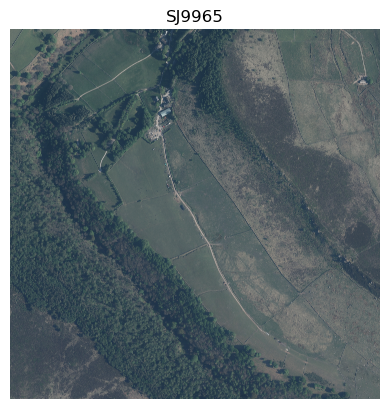

In [ ]:
## Load image:

example_tiff_file = 'SJ9965.tif'
# example_tiff_file = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/SE0800_lc_2022_mask.tif'
example_tiff_path = os.path.join(path_dict['image_path'], example_tiff_file)
# example_tiff_path = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/SK2196_lc_2022_mask.tif'
ex_tile = lca.load_tiff(tiff_file_path=example_tiff_path, datatype='da')
lcv.plot_image_simple(im=ex_tile, name_file=example_tiff_file)

# tmp = lcv.plot_image_as_patches(im=ex_tile, name_file=example_tiff_file)

### Automatically intersect LC polygons with tiles; and create rasterized patches:

In [ ]:
## Load landcover polygons:

df_lc_80s, mapping_class_inds = lca.load_landcover(pol_path=path_dict['lc_80s_path'])
# df_lc_80s = lca.load_pols(pol_path='/home/tplas/repos/cnn-land-cover/content/evaluation_polygons/Landscape_Character_80s_2022.shp')
df_lc_80s = lca.test_validity_geometry_column(df=df_lc_80s)
df_lc_80s = lca.add_main_category_column(df_lc=df_lc_80s) 
df_lc_80s

,AREA,PERIMETER,LC_N_80,LC_D_80,MI_PRINX,geometry,Class_Code
0,2.288935e+05,1931.281171,19,Improved Pasture,1,"POLYGON ((407724.666 411168.713, 407854.641 41...",E
1,8.103939e+05,6180.868624,12,Upland Heath/Grass Mosaic,2,"POLYGON ((407267.642 410992.244, 407326.372 41...",D
2,3.024182e+06,30493.715242,7,Upland Grass Moor,3,"POLYGON ((405616.816 409724.857, 405615.571 40...",D
3,3.141201e+06,17829.297205,8,Blanket Peat Grass Moor,4,"POLYGON ((406402.661 410926.453, 406419.695 41...",D
4,5.524007e+03,360.239964,20,Rough Pasture,5,"POLYGON ((405569.382 410874.398, 405584.644 41...",E
...,...,...,...,...,...,...,...
8477,2.946860e+03,210.674150,19,Improved Pasture,8478,"POLYGON ((416356.527 348866.777, 416357.591 34...",E
8478,1.588031e+03,186.955561,1,Broadleaved High Forest,8479,"POLYGON ((412660.720 348649.559, 412658.280 34...",C
8479,6.253066e+03,340.410463,36,Isolated Farmsteads (>0.25 ha),8480,"POLYGON ((412871.439 348609.371, 412858.033 34...",H
8480,1.770921e+05,2285.262979,2,Coniferous High Forest,8481,"POLYGON ((411786.076 405491.149, 411803.349 40...",C


In [ ]:
# df_lc_80s = df_lc_80s.drop('AREA', axis=1)
# df_lc_80s['area'] = df_lc_80s['geometry'].area

df_h = df_lc_80s[df_lc_80s['Class_Code'] == 'H']
area_h = df_h['area'].sum()
total_area = df_lc_80s['area'].sum()

print('Total area: ', total_area / 1e4)
print('Area H: ', area_h / 1e4)
print('Percentage H: ', area_h/total_area)



Total area:  143835.0136998267
Area H:  2935.024649254558
Percentage H:  0.02040549497481707


In [ ]:
# ## Get intersection of polygons with tiles
# # df_tiles = lca.create_df_with_tiff_coords(tiff_paths=lca.get_all_tifs_from_dir(path_dict['image_path']), verbose=1)  # get df of square polygons of tiles 
# df_tiles = lca.create_df_with_tiff_coords(tiff_paths=lca.get_all_tifs_from_dir('/home/tplas//data/gis/most recent APGB 12.5cm aerial/gradbach_6tiles/12.5cm Aerial Photo/117383-1_RGB_1_Shape/tiles/'), verbose=1)  # get df of square polygons of tiles 
# # df_tiles = lca.create_df_with_tiff_coords(tiff_paths=lca.get_all_tifs_from_dir(path_dict['image_path']), verbose=1)  # get df of square polygons of tiles 
# dict_intersect_pols = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_tiles)

In [ ]:
## Load shp files of tiles and intersect with PD LC:

df_tiles_sample = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/CDE_training_tiles/CDE_training_tiles.shp')
# df_tiles_sample = lca.load_pols('/home/tplas/data/gis/most recent APGB 12.5cm aerial/urban_tiles/3_urban_tiles/3_urban_tiles.shp')
dict_intersect_pols_tiles_sample = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_tiles_sample, col_name='PLAN_NO',
                                                          extract_main_categories_only=False)
df_tiles_sample_lc = pd.concat(list(dict_intersect_pols_tiles_sample.values())).reset_index(drop=True)


100%|██████████| 11/11 [00:00<00:00, 49.98it/s]


In [ ]:
# lca.add_main_category_index_column(dict_intersect_pols_tiles_sample['SE1301'])
dict_intersect_pols_tiles_sample['SE1301']

,geometry,LC_N_80,LC_D_80
0,"MULTIPOLYGON (((412999.996 401267.618, 413037....",7,Upland Grass Moor
1,"POLYGON ((413781.665 401999.998, 413797.467 40...",8,Blanket Peat Grass Moor
2,"POLYGON ((413999.998 401892.099, 413961.692 40...",6,Upland Heath


In [ ]:
## Convert all polygons labels to raster and save:

dict_shp = dict_intersect_pols_tiles_sample
# save_mask_dir = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/'
# save_mask_dir = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/urban_tiles/tiles/117637_20221207/tile_masks/'
# save_mask_dir = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/tile_masks/'
save_mask_dir = '/home/tplas/data/gis/tmp_trial/original/'
for key_tile, df_tile in tqdm(dict_shp.items()):
    # dict_shp[key_tile] = lca.add_main_category_index_column(df_tile)
    ex_raster = lca.convert_shp_mask_to_raster(df_shp=df_tile, filename=key_tile + '_lc_80s_mask', 
                                maskdir=save_mask_dir, 
                                # col_name='class_ind',
                                col_name='LC_N_80',
                                # ex_tile=ex_raster,
                                # resolution=(-0.125, 0.125),
                                plot_raster=False, # whether to plot
                                save_raster=True, # whether to store on disk
                                verbose=0)
    # assert ex_raster['class_ind'].shape == (8000, 8000), key_tile
    assert ex_raster['LC_N_80'].shape == (8000, 8000), key_tile


100%|██████████| 11/11 [00:38<00:00,  3.48s/it]


### Some plots of class distributions:

Text(0.5, 1.0, 'Distribution of LC of entire PD')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


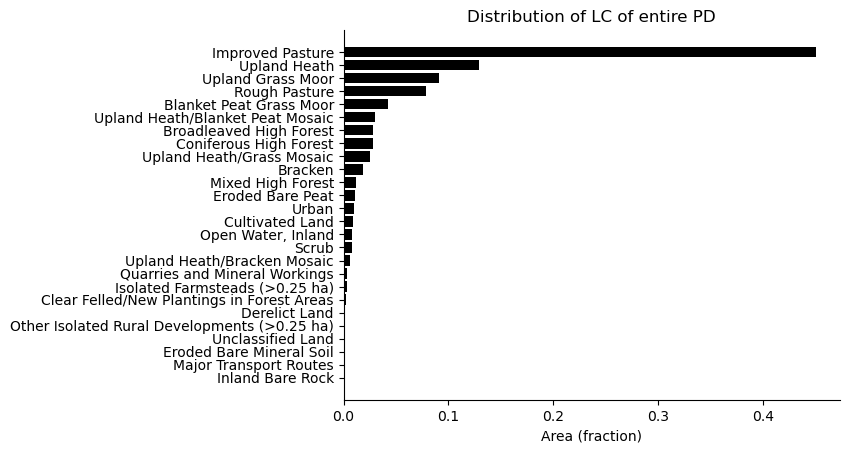

In [ ]:
ax_distr, _ = lcv.plot_distr_classes_from_shape(df_lc=df_lc_80s)
ax_distr.set_title('Distribution of LC of entire PD')

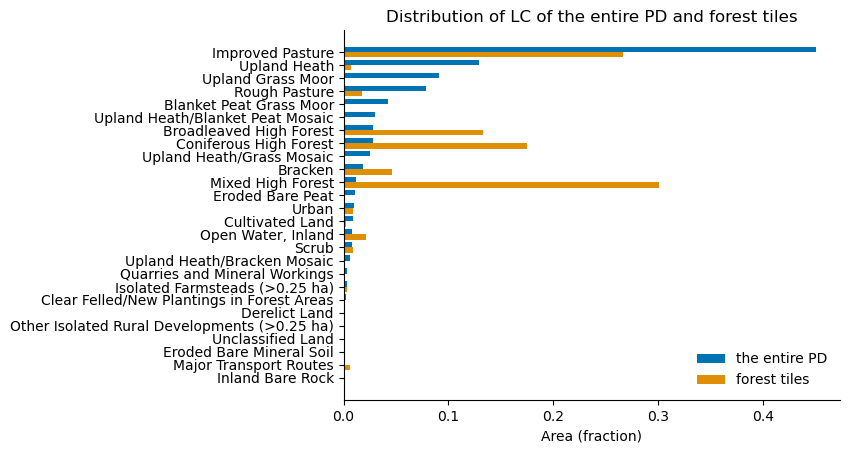

In [ ]:
ax_distr, _ = lcv.plot_distr_classes_from_multiple_shapes(dict_dfs_lc={'the entire PD': df_lc_80s, 'forest tiles': df_tiles_few_changes_lc})

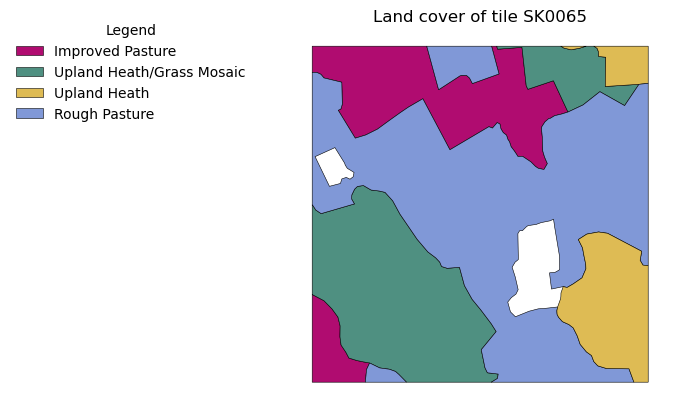

In [ ]:
_ = lcv.plot_lc_from_gdf_dict(df_pols_tiles=dict_intersect_pols, tile_name="SK0065")

Current data size cube is 512.128008 MB
New cube data size is 64.128008 MB


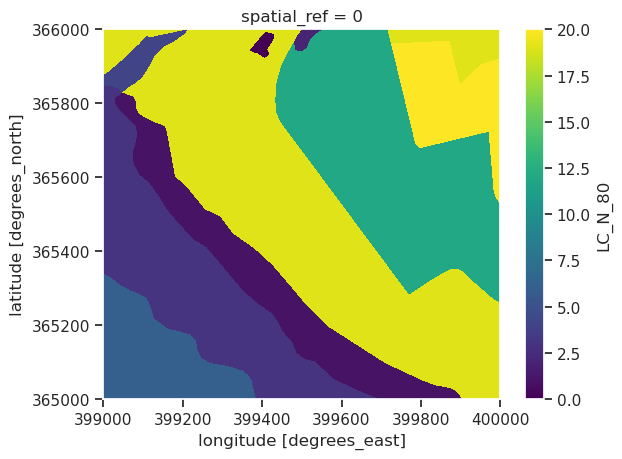

In [ ]:
## Example: convert polygons labels to raster:
dict_shp = dict_intersect_pols
key_tile = "SJ9965"

ex_raster = lca.convert_shp_mask_to_raster(df_shp=dict_shp[key_tile], filename=key_tile + '_lc_80s_mask', 
                                plot_raster=True, # whether to plot
                                save_raster=False, # whether to store on disk
                                verbose=1)

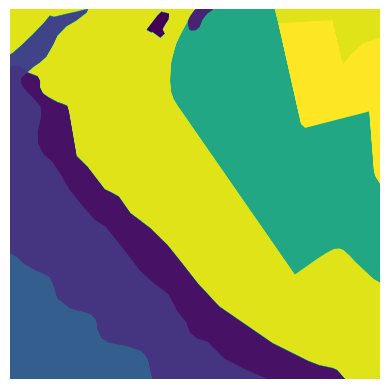

In [ ]:
## Load saved raster mask
ex_mask_tif = lca.load_tiff(tiff_file_path=os.path.join(path_dict['mask_path'], 'SJ9965' + '_lc_80s_mask.tif'))
lcv.plot_image_simple(im=ex_mask_tif)

## Create Patches and save:

In [ ]:
# list_tiff_files = lca.get_all_tifs_from_dir(dirpath='/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/')
list_tiff_files = lca.get_all_tifs_from_dir(dirpath='/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/')
# list_mask_files = lca.get_all_tifs_from_dir(dirpath='/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/tile_masks/')list_mask_files = lca.get_all_tifs_from_dir(dirpath='/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/tile_masks/')
list_mask_files = lca.get_all_tifs_from_dir(dirpath='/home/tplas/data/gis/tmp_trial/original/')

print(f'Found {len(list_tiff_files)} images and {len(list_mask_files)} masks')
print(list_tiff_files[:4])

Found 11 images and 11 masks
['/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/SK0560.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/SK0796.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/SK2669.tif', '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/SK2567.tif']


## Continue:

In [ ]:
# dir_im_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/images/'
# dir_mask_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/masks/'
dir_im_patches = '/home/tplas/data/gis/tmp_trial/original/images/'
dir_mask_patches = '/home/tplas/data/gis/tmp_trial/original/masks/'

lca.create_and_save_patches_from_tiffs(list_tiff_files=list_tiff_files, list_mask_files=list_mask_files,
                                       dir_im_patches=dir_im_patches, dir_mask_patches=dir_mask_patches,
                                       mask_fn_suffix='_lc_80s_mask.tif',
                                       save_files=True)

## Notebook to create label mapping transformations
- Map old labels to new labels
- Old labels: 1980s classification scheme
- Multiple new label schemes possible.


In [ ]:
# save_folder = '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/'
dict_mapping = lca.create_empty_label_mapping_dict()

In [4]:
tmp = lca.create_new_label_mapping_dict(save_mapping=True, mapping_type='all_relevant_subclasses')

adding scrub
adding wetland
adding transport


### Create table with key for LC schema:
 - Old 80s schema
 - New 2022 schema 
 - Mapping betweens those 
 - Code + name + index

In [ ]:
df_schema = lca.create_df_mapping_labels_2022_to_80s()

adding scrub
adding wetland
adding transport


In [ ]:
df_schema

,description_2022,description_80s,code_80s,code_2022,index_2022,index_80s
0,NO CLASS,NO CLASS,0,0,0,0
1,Broadleaved High Forest,Broadleaved High Forest,C1,C1,1,1
2,Coniferous High Forest,Coniferous High Forest,C2,C2,2,2
3,Mixed High Forest,Mixed High Forest,C3,C3,3,3
4,Scrub,Scrub,C4,C4a,4,4
5,Scrub Pasture,Scrub,C4,C4b,5,4
6,Woodland/Scrub Edge,Scrub,C4,C4c,6,4
7,Clear Felled/New Plantings in Forest Areas,Clear Felled/New Plantings in Forest Areas,C5,C5,7,5
8,Upland Heath,Upland Heath,D1,D1,8,6
9,Upland Grass Moor,Upland Grass Moor,D2b,D2b,9,7


## Create new selection of tiles for NTM data:

In [ ]:
df_tiles_train = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/CDE_training_tiles/CDE_training_tiles.shp')
df_tiles_eval = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')
df_tiles_concat = pd.concat([df_tiles_train, df_tiles_eval], axis=0)
df_tiles_concat = df_tiles_concat.reset_index(drop=True)

list_tiles_eval_exclude = ['SE0503', 'SE0705', 'SE0800', 'SE1203', 'SE1400', 'SK0684', 
                           'SK0686', 'SK0790', 'SK0896', 'SK0988', 'SK1399', 'SK1798', 
                           'SK1896', 'SK1992', 'SK1998', 'SK2091', 'SK2096', 'SK2196', 
                           'SK2777',   # up until here: eval without trees
                           'SK0752', 'SK0961', 'SJ9566', 'SK1588', 'SK1360',  # this row; eval already in NTM
                           'SE1301', 'SK0792', 'SK0796', 'SK1095', 'SK1295', 'SK2969']  # this row: training tiles without trees 

In [ ]:
df_tiles_ntm = df_tiles_concat[np.logical_not(df_tiles_concat['PLAN_NO'].isin(list_tiles_eval_exclude))]
assert len(df_tiles_ntm) == 31

In [ ]:
df_tiles_ntm.to_file('/home/tplas/repos/cnn-land-cover/content/tree_tiles/tiles_ntm_data/tiles_ntm_data.shp')

## Add NFI data to tile outlines.. v2

In [ ]:
df_tiles_outline = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')
print(f'Loaded {len(df_tiles_outline)} tiles.')

## Load NFI data:
df_nfi = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/NFI_data/NFI_pd_incl_ambiguous.shp')
print(f'Loaded {len(df_nfi)} NFI polygons.')
nfi_class_col = 'Class_low'
df_nfi = df_nfi.drop(columns=[col_name for col_name in df_nfi.columns if col_name not in ['Class_low', 'geometry']])
df_nfi['source'] = 'NFI 2020 retrieved 2023-02-15' 

## Load main-class annotated + FGH layer:
df_fgh_main = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/evaluation_polygons/landscape_character_2022_FGH-override/landscape_character_2022_FGH-override.shp')
print(f'Loaded {len(df_fgh_main)} FGH polygons.')
filepath_manual_fgh_layer = '/home/tplas/data/gis/tmp_fgh_layer/tmp_fgh_layer.shp'
date_fgh_modified = str(datetime.datetime.strptime(time.ctime(os.path.getmtime(filepath_manual_fgh_layer)), '%a %b %d %H:%M:%S %Y').date())
source_fgh = f'OS NGD retrieved {date_fgh_modified}'

## Remove all tiny FGH polygons:
list_inds_remove = [] 
list_inds_keep = []
for ii in range(len(df_fgh_main)):
    label = df_fgh_main['Class_low'][ii].upper()
    if len(label)  == 1:
        if label in ['C', 'D', 'E']:
            list_inds_remove.append(ii)
        elif label in ['F', 'G', 'H']:
            if df_fgh_main.iloc[ii]['geometry'].area < 100:
                list_inds_remove.append(ii)
            else:
                list_inds_keep.append(ii) 
        else:
            raise ValueError('Unknown label.')
    else:
        list_inds_keep.append(ii)

assert len(list_inds_remove) + len(list_inds_keep) == len(df_fgh_main) 
df_fgh_main = df_fgh_main.iloc[np.array(list_inds_keep)]
df_fgh_main = df_fgh_main.reset_index(drop=True)
df_fgh_main = df_fgh_main.drop(columns=['Class_high'])

## Add sources:
list_sources = []
for ii in range(len(df_fgh_main)):
    label = df_fgh_main['Class_low'][ii].upper()
    if len(label)  == 1:
        if label in ['C', 'D', 'E']:
            raise ValueError('Still some CDE labels.')
        elif label in ['F', 'G', 'H']:
            list_sources.append('Manual annotation DA SG 2023')
        else:
            raise ValueError('Unknown label.')
    else:
        if label[0] in ['C', 'D', 'E']:
            list_sources.append('Manual annotation DA SG 2023')
        elif label[0] in ['F', 'G', 'H']:
            list_sources.append(source_fgh)
        else:
            raise ValueError(f'Unknown label {label}.')

assert len(list_sources) == len(df_fgh_main)
df_fgh_main['source'] = list_sources
assert (set(df_nfi.columns) == set(df_fgh_main.columns)), f'Columns of NFI and FGH dataframes are not the same: {df_nfi.columns} vs {df_fgh.columns}'

df_fgh_main = lca.test_validity_geometry_column(df_fgh_main)
df_nfi = lca.test_validity_geometry_column(df_nfi)

Loaded 50 tiles.
Loaded 2935 NFI polygons.
Loaded 1807 FGH polygons.
Geometry Ring Self-intersection[407643.878683077 352269.720591962] for inds [984]
Attempting to make valid
Done
Geometry Ring Self-intersection[396662.087 372036.395] for inds [2088]
Attempting to make valid
Done


In [ ]:
df_merged_manual_layers = pd.concat([df_nfi, df_fgh_main], axis=0)
df_merged_manual_layers = df_merged_manual_layers.reset_index(drop=True)
dict_merged = lca.get_pols_for_tiles(df_pols=df_merged_manual_layers, df_tiles=df_tiles_outline, 
                            col_name='PLAN_NO', 
                            col_ind_name='Class_low', col_class_name='source', verbose=0)


100%|██████████| 50/50 [00:00<00:00, 56.24it/s]


In [ ]:
list_manual_annotated_tiles = ['SK0752', 'SK0852', 'SK1357', 'SK2055']
for tilename in list_manual_annotated_tiles:
    ## Get rid of 0 because it's just tiny stripes
    dict_merged[tilename] = dict_merged[tilename][dict_merged[tilename]['Class_low'] != '0']

for tilename, gdf in dict_merged.items():
    # print(f'{tilename}: {len(gdf)}')
    
    dict_merged[tilename] = gdf.explode(index_parts=True).reset_index(drop=True)
    # assert that all goemetry re Polygon
    for ii in range(len(dict_merged[tilename])):
        assert dict_merged[tilename]['geometry'][ii].geom_type == 'Polygon', f'Found a non-Polygon geometry in {tilename}'



In [ ]:
## removing overlap between NFi and FGH
for tilename, gdf in dict_merged.items():  # using new loop to make sure exploding is ok 
    ## see if polygons with NFI source intersect with any other polygons:
    inds_nfi = np.where(gdf['source'] == 'NFI 2020 retrieved 2023-02-15')[0]

    if len(inds_nfi) > 0:
        
        gdf_fgh = gdf[gdf['source'] == source_fgh] 
        if len(gdf_fgh) == 0:
            continue
        merged_pol_non_nfi = gdf_fgh['geometry'].unary_union
        list_new_pols = []
        for ind in inds_nfi:
            pol_orig = gdf.iloc[ind]['geometry']
            pol_diff = pol_orig.difference(merged_pol_non_nfi)
            if pol_diff != pol_orig:  # overlap 
                list_new_pols.append(pol_diff)
            else:
                list_new_pols.append(pol_orig)

        assert len(gdf.iloc[inds_nfi]) == len(list_new_pols)
        # if len(list_new_pols) == 1:
        list_new_pols = gpd.GeoSeries(list_new_pols)
        # break
        gdf.loc[inds_nfi, 'geometry'] = list_new_pols
        gdf = lca.test_validity_geometry_column(gdf)
        gdf = gdf.explode(index_parts=True).reset_index(drop=True)
        gdf = lca.test_validity_geometry_column(gdf)
        dict_merged[tilename] = gdf 
        

In [ ]:
df_merged = pd.concat(list(dict_merged.values())).reset_index(drop=True)
df_merged = df_merged[df_merged['geometry'].area > 1]
df_merged = df_merged.reset_index(drop=True)
df_merged = lca.test_validity_geometry_column(df_merged) 
df_merged.to_file('/home/tplas/repos/cnn-land-cover/content/evaluation_polygons/landscape_character_2022_detailed_CFGH-override/landscape_character_2022_detailed_CFGH-override.shp')
df_merged

,Class_low,source,geometry
0,0,0,"POLYGON ((405000.003 403000.002, 405000.003 40..."
1,0,0,"POLYGON ((406999.999 404999.999, 406999.999 40..."
2,C,NFI 2020 retrieved 2023-02-15,"POLYGON ((408741.500 400245.000, 408753.000 40..."
3,G2,OS NGD retrieved 2023-01-10,"POLYGON ((408320.500 400187.500, 408319.500 40..."
4,G2,OS NGD retrieved 2023-01-10,"POLYGON ((408384.500 400253.000, 408382.000 40..."
...,...,...,...
1358,F2,OS NGD retrieved 2023-01-10,"POLYGON ((427935.150 377017.270, 427933.890 37..."
1359,F2,OS NGD retrieved 2023-01-10,"POLYGON ((427973.790 377059.340, 427960.350 37..."
1360,H1b,OS NGD retrieved 2023-01-10,"POLYGON ((427948.110 377928.370, 427949.420 37..."
1361,0,0,"POLYGON ((427000.003 377000.004, 427000.003 37..."


In [ ]:
# gdf.plot(column='source', figsize=(15, 15))
# plt.axis('off')

## Create tile outlines + override layers for manual annotation
- Get list of tiles
- Get tile outlines 
- Override with NFI (some detailed, some not) + add source 
- Override with NGD (detailed) + add source 

In [87]:
# df_tiles_outline = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')
df_tiles_outline = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/evaluation_sample_50tiles/eval_2_30tiles_outlines.shp')
print(f'Loaded {len(df_tiles_outline)} tiles.')

## Load FGH data:
filepath_manual_fgh_layer = '/home/tplas/data/gis/tmp_fgh_layer/tmp_fgh_layer.shp'
df_fgh = lca.load_pols(filepath_manual_fgh_layer)
date_fgh_modified = str(datetime.datetime.strptime(time.ctime(os.path.getmtime(filepath_manual_fgh_layer)), '%a %b %d %H:%M:%S %Y').date())
   
assert len(df_fgh) == 18056, 'not as expected'
print(f'Loaded {len(df_fgh)} FGH polygons.')
## Replace lc_label column by Class_low column:
df_fgh['Class_low'] = df_fgh['lc_label']
df_fgh = df_fgh.drop(columns=['lc_label'])
df_fgh['source'] = f'OS NGD retrieved {date_fgh_modified}'

## Load NFI data:
df_nfi = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/NFI_data/NFI_pd_incl_ambiguous.shp')
assert len(df_nfi) == 2935, 'not as expected'
print(f'Loaded {len(df_nfi)} NFI polygons.')
nfi_class_col = 'Class_low'
df_nfi = df_nfi.drop(columns=[col_name for col_name in df_nfi.columns if col_name not in ['Class_low', 'geometry']])
df_nfi['source'] = 'NFI 2020 retrieved 2023-02-15' 



Loaded 30 tiles.
Loaded 18056 FGH polygons.
Loaded 2935 NFI polygons.


In [88]:
# ## Merge NFI and FGH layers into one df. Resolve overlaps by giving priority to FGH layer:

# df_diff = gpd.overlay(df_nfi, df_fgh, how='difference')  # Get df pred polygons that are not in df fgh 
# df_diff = df_diff.explode().reset_index(drop=True)
# df_intersect = gpd.overlay(df_nfi, df_fgh, how='intersection')  # Get overlap between df pred and df fgh
# df_intersect['Class_low'] = df_intersect['Class_low_2']  #  FGH layer has priority (and was 2nd arg in overlay() above)
# df_intersect['source'] = df_intersect['source_2']
# df_intersect = df_intersect.drop(['Class_low_1', 'Class_low_2'], axis=1)
# df_intersect = df_intersect.drop(['source_1', 'source_2'], axis=1)
# df_intersect = df_intersect.explode().reset_index(drop=True)  # in case multiple polygons are created by intersection
# df_merged_manual_layers = gpd.GeoDataFrame(pd.concat([df_diff, df_intersect], ignore_index=True))  # Concatenate all polygons


In [144]:
# dict_nfi, df_nfi_in_tiles = lca.get_pols_for_tiles_simple(df_pols=df_nfi, df_tiles=df_tiles_outline)
# dict_fgh, df_fgh_in_tiles = lca.get_pols_for_tiles_simple(df_pols=df_fgh, df_tiles=df_tiles_outline)

df_merged_manual_layers = pd.concat([df_nfi, df_fgh], axis=0)
df_merged_manual_layers = df_merged_manual_layers.reset_index(drop=True)
dict_merged = lca.get_pols_for_tiles(df_pols=df_merged_manual_layers, df_tiles=df_tiles_outline, col_name='PLAN_NO', 
                            col_ind_name='Class_low', col_class_name='source', verbose=0)
assert (set(df_nfi.columns) == set(df_fgh.columns)), f'Columns of NFI and FGH dataframes are not the same: {df_nfi.columns} vs {df_fgh.columns}'

## Create dict for each tile with merged nfi and fgh data:
# dict_merged = {} 
# for tilename, df_nfi_tile in tqdm(dict_nfi.items()):
#     df_fgh_tile = dict_fgh[tilename]
#     df_merged = pd.concat([df_nfi_tile, df_fgh_tile], axis=0)
#     df_merged = df_merged.reset_index(drop=True)
#     dict_merged[tilename] = df_merged

100%|██████████| 30/30 [00:04<00:00,  6.46it/s]


In [145]:
## check if any polygons overlap with others in dict_nfi['SK0852'] : 
# tmp = dict_nfi['SK0852'].copy()
verbose = 0

for tilename, df_tile in tqdm(dict_merged.items()):
    # if tilename != 'SK2396':
        # continue
    tmp = df_tile.copy()
    # list_conflicts = []
    conflict_exists = True 
    while conflict_exists:

        for ii in range(len(tmp)):
            for jj in range(ii, len(tmp)):
                # print(ii, jj)
                to_break = False 
                if ii != jj and tmp.iloc[ii]['geometry'].intersection(tmp.iloc[jj]['geometry']).area > 0 and tmp.iloc[ii]["source"] != tmp.iloc[jj]["source"]:
                    assert tmp.iloc[ii]["source"] != tmp.iloc[jj]["source"]
                    # list_conflicts.append((ii, jj))
                    if verbose > 0:
                        print(f'Tile {tilename}, inds {ii, jj}. Class_low of both: {tmp.iloc[ii]["Class_low"]}, {tmp.iloc[jj]["Class_low"]}')
                    # print(f'Source of both: {tmp.iloc[ii]["source"]}, {tmp.iloc[jj]["source"]}')
                    # print(f'Area of overlap and difference: {tmp.iloc[ii]["geometry"].intersection(tmp.iloc[jj]["geometry"]).area}, {tmp.iloc[ii]["geometry"].difference(tmp.iloc[jj]["geometry"]).area}')

                    source_replace = 'NFI 2020 retrieved 2023-02-15'
            
                    source_ii = tmp.iloc[ii]["source"]
                    source_jj = tmp.iloc[jj]["source"]
                    if source_ii == source_replace:
                        replace_ind = ii 
                        other_ind = jj
                        source_other = source_jj
                    else:
                        replace_ind = jj
                        other_ind = ii
                        source_other = source_ii
                    
                    area_intersection = tmp.iloc[replace_ind]['geometry'].intersection(tmp.iloc[other_ind]['geometry'])
                    area_difference = tmp.iloc[replace_ind]['geometry'].difference(tmp.iloc[other_ind]['geometry'])

                    # add new row with intersection geometry and other source:
                    # tmp = tmp.append({'geometry': area_intersection, 'Class_low': tmp.iloc[other_ind]['Class_low'],
                    #                 'source': source_other}, ignore_index=True)
                    tmp = tmp.append({'geometry': area_difference, 'Class_low': tmp.iloc[replace_ind]['Class_low'],
                                    'source': source_replace}, ignore_index=True)
                    tmp.drop(replace_ind, inplace=True)
                    tmp = tmp.reset_index(drop=True)
                    if verbose > 0:
                        print(f'area intersection: {area_intersection.area}, area difference: {area_difference.area}')
                    conflict_exists = True
                    to_break = True 
                    break
            if to_break:
                break
        if not to_break:
            conflict_exists = False
                
    
    tmp = tmp.reset_index(drop=True)
    tmp = lca.filter_only_polygons_from_geometry_column(tmp, area_threshold=1)
    ## ensure source of 0 is 0:
    tmp.loc[tmp['Class_low'] == 0, 'source'] = '0'
    dict_merged[tilename] = tmp.copy() # update dict_nfi with new polygons

  0%|          | 0/30 [00:00<?, ?it/s]../scripts/land_cover_analysis.py:517: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df = df.explode()
../scripts/land_cover_analysis.py:517: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df = df.explode()
../scripts/land_cover_analysis.py:517: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df = df.explode()
../scripts/land_cover_analysis.py:517: FutureWarning: Currently, index_parts defaults to True, but in the future, it will 

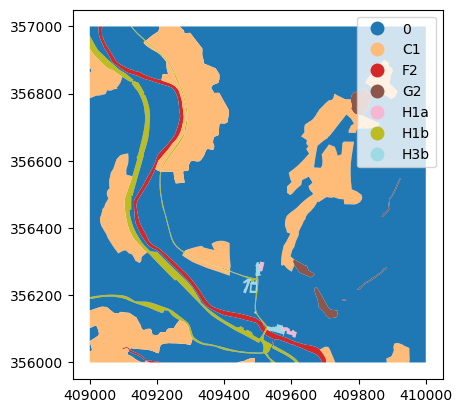

In [147]:
dict_merged['SK0956'].plot(column='Class_low', cmap='tab20', legend=True)

In [148]:
df_merged = pd.concat(list(dict_merged.values())).reset_index(drop=True)
df_merged

,Class_low,source,geometry
0,0,0,"POLYGON ((404000.001 406999.997, 404000.001 40..."
1,F2,OS NGD retrieved 2023-01-10,"POLYGON ((405000.003 405372.630, 405007.500 40..."
2,0,0,"POLYGON ((405000.003 404999.999, 405000.003 40..."
3,0,0,"POLYGON ((409999.998 403000.002, 409999.998 40..."
4,C,NFI 2020 retrieved 2023-02-15,"POLYGON ((411367.253 400097.542, 411379.997 40..."
...,...,...,...
568,C1,NFI 2020 retrieved 2023-02-15,"POLYGON ((426290.750 377986.500, 426275.730 37..."
569,G2,OS NGD retrieved 2023-01-10,"POLYGON ((426272.570 377390.530, 426274.640 37..."
570,G2,OS NGD retrieved 2023-01-10,"POLYGON ((426066.580 377851.980, 426066.480 37..."
571,0,0,"POLYGON ((426000.000 377022.960, 426000.000 37..."


In [149]:
df_merged = lca.filter_only_polygons_from_geometry_column(df_merged, area_threshold=1)

../scripts/land_cover_analysis.py:517: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df = df.explode()


In [150]:
df_merged.to_file('/home/tplas/test/test_new_cfgh.shp')

In [151]:
df_eval = lca.load_pols('../content/evaluation_polygons/landscape_character_2022_detailed_CFGH-override/landscape_character_2022_detailed_CFGH-override.shp')


In [153]:
df_eval

,Class_low,source,geometry
0,0,0,"POLYGON ((405999.997 403999.995, 405999.997 40..."
1,C,NFI 2020 retrieved 2023-02-15,"POLYGON ((408741.500 400245.000, 408753.000 40..."
2,G2,OS NGD retrieved 2023-01-10,"POLYGON ((408320.500 400187.500, 408319.500 40..."
3,G2,OS NGD retrieved 2023-01-10,"POLYGON ((408384.500 400253.000, 408382.000 40..."
4,0,0,"POLYGON ((408000.001 400000.000, 408000.001 40..."
...,...,...,...
2716,E2a,None,"POLYGON ((419753.536 375872.000, 419768.002 37..."
2717,E2a,None,"POLYGON ((419768.002 375884.370, 419751.017 37..."
2718,E2b,None,"POLYGON ((419768.002 375882.402, 419753.536 37..."
2719,E2b,None,"POLYGON ((419768.001 375930.218, 419768.001 37..."


In [154]:
df_merged

,Class_low,source,geometry
0,0,0,"POLYGON ((404000.001 406999.997, 404000.001 40..."
1,F2,OS NGD retrieved 2023-01-10,"POLYGON ((405000.003 405372.630, 405007.500 40..."
2,0,0,"POLYGON ((405000.003 404999.999, 405000.003 40..."
3,0,0,"POLYGON ((409999.998 403000.002, 409999.998 40..."
4,C,NFI 2020 retrieved 2023-02-15,"POLYGON ((411367.253 400097.542, 411379.997 40..."
...,...,...,...
568,C1,NFI 2020 retrieved 2023-02-15,"POLYGON ((426290.750 377986.500, 426275.730 37..."
569,G2,OS NGD retrieved 2023-01-10,"POLYGON ((426272.570 377390.530, 426274.640 37..."
570,G2,OS NGD retrieved 2023-01-10,"POLYGON ((426066.580 377851.980, 426066.480 37..."
571,0,0,"POLYGON ((426000.000 377022.960, 426000.000 37..."


In [152]:
df_new_eval = pd.concat([df_eval, df_merged], axis=0, ignore_index=True)

In [156]:
df_new_eval.to_file('../content/evaluation_polygons/landscape_character_2022_detailed_CFGH-override/landscape_character_2022_detailed_CFGH-override.shp')

In [155]:
df_new_eval

,Class_low,source,geometry
0,0,0,"POLYGON ((405999.997 403999.995, 405999.997 40..."
1,C,NFI 2020 retrieved 2023-02-15,"POLYGON ((408741.500 400245.000, 408753.000 40..."
2,G2,OS NGD retrieved 2023-01-10,"POLYGON ((408320.500 400187.500, 408319.500 40..."
3,G2,OS NGD retrieved 2023-01-10,"POLYGON ((408384.500 400253.000, 408382.000 40..."
4,0,0,"POLYGON ((408000.001 400000.000, 408000.001 40..."
...,...,...,...
3289,C1,NFI 2020 retrieved 2023-02-15,"POLYGON ((426290.750 377986.500, 426275.730 37..."
3290,G2,OS NGD retrieved 2023-01-10,"POLYGON ((426272.570 377390.530, 426274.640 37..."
3291,G2,OS NGD retrieved 2023-01-10,"POLYGON ((426066.580 377851.980, 426066.480 37..."
3292,0,0,"POLYGON ((426000.000 377022.960, 426000.000 37..."


In [ ]:
df_test = df_nfi

for ii in range(len(df_test)):
    for jj in range(ii, len(df_test)):
        if ii != jj and df_test.iloc[ii]['geometry'].intersection(df_test.iloc[jj]['geometry']).area > 1e-1:
            assert False, f'Polygons {ii} and {jj} still overlap with area {df_test.iloc[ii]["geometry"].intersection(df_test.iloc[jj]["geometry"]).area}'

In [ ]:
# dict_intersect_pols_tiles_sample = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=df_tiles_sample, col_name='PLAN_NO',
#                                                           extract_main_categories_only=False)
# df_tiles_sample_lc = pd.concat(list(dict_intersect_pols_tiles_sample.values())).reset_index(drop=True)

dict_intersect_pols_tiles_sample = lca.get_pols_for_tiles(df_pols=df_nfi, df_tiles=df_tiles_sample, col_name='PLAN_NO',
                                                          extract_main_categories_only=False)
df_tiles_sample_lc = pd.concat(list(dict_intersect_pols_tiles_sample.values())).reset_index(drop=True)

## Create mask using habitat data
- Create mapping and save
- Add LC codes to habitat shape files
- Merge prio & non-prio? 
- Delete all irrelevant polygons

In [ ]:
df_merged = lca.prepare_habitat_data(save_df=True, get_intersection=True, add_tag_col=True)

In [ ]:
df_merged.to_file('../content/habitat_data_annotations/habitat_data_annotations.shp')

In [ ]:
df_merged = gpd.read_file('../content/habitat_data_annotations/habitat_data_annotations.shp')

In [ ]:
df_merged[df_merged['SEL_TRAIN'] == 1].groupby('Class_low').sum()

,SEL_TRAIN,area
Class_low,,
D1,6,3152340.320
D2a,7,5255077.822
F3a,3,6041197.782
F3d,10,450066.751


## Use peaty soils to relabel eval data

In [67]:
df_eval = lca.load_pols('../content/evaluation_polygons/landscape_character_2022_detailed_CFGH-override/landscape_character_2022_detailed_CFGH-override.shp')

In [73]:
df_eval.source.unique()

array(['0', 'NFI 2020 retrieved 2023-02-15',
       'OS NGD retrieved 2023-01-10', 'Manual annotation DA SG 2023',
       'Manual annotation DA SG 2023 (using Natural England Peaty Soils Location)'],
      dtype=object)

In [72]:
inds_new_annot = np.where([x is None for x in df_eval['source']])[0]
# inds_new_annot = np.where([x == 'c' for x in df_eval['source']])[0]
print('found ', len(inds_new_annot))
df_eval.loc[inds_new_annot, 'source'] = 'Manual annotation DA SG 2023'

found  1


In [89]:
# df_eval[df_eval['Class_low'] == 'D2c']
df_eval['Class_low'].unique()

array(['0', 'C', 'G2', 'H2a', 'F2', 'H1b', 'H3b', 'C1', 'C4', 'H', 'H1a',
       'C2', 'C5', 'C3', 'E2a', 'F3d', 'E2b', 'H3a', 'F3a', 'D2d', 'D3',
       'D1a', 'D6b', 'D6c', 'D7a', 'D2b'], dtype=object)

In [81]:
df_eval.loc[df_eval['Class_low'] == 'D1', 'Class_low'] = 'D1a'

,Class_low,source,geometry
1660,D1a,Manual annotation DA SG 2023,"POLYGON ((424756.632 396999.999, 424767.996 39..."
1661,D1a,Manual annotation DA SG 2023,"POLYGON ((424063.996 396359.999, 424068.925 39..."
1733,D1a,Manual annotation DA SG 2023,"POLYGON ((407895.999 405117.111, 407895.999 40..."
1741,D1a,Manual annotation DA SG 2023,"POLYGON ((407831.999 405168.003, 407844.737 40..."
1753,D1a,Manual annotation DA SG 2023,"POLYGON ((412183.144 403615.995, 412184.535 40..."
...,...,...,...
4337,D1a,Manual annotation DA SG 2023,"POLYGON ((427448.003 377423.998, 427512.003 37..."
4338,D1a,Manual annotation DA SG 2023,"POLYGON ((427256.003 377231.998, 427320.003 37..."
4348,D1a,Manual annotation DA SG 2023,"POLYGON ((407492.753 390935.997, 407496.491 39..."
4349,D1a,Manual annotation DA SG 2023,"POLYGON ((407407.638 390898.165, 407402.750 39..."


In [90]:
tmp = lca.use_soil_data_to_overwrite(df_lc=df_eval)

Validating df_LC
Geometry Ring Self-intersection[405166.645500001 354069.537799999] for inds [3448]
Attempting to make valid
Done
Geometry Ring Self-intersection[407379.638966848 352904.669116294] for inds [465]
Attempting to make valid
Done
Geometry Ring Self-intersection[407495.557080073 405488.00284208] for inds [1722]
Attempting to make valid
Done
Geometry Ring Self-intersection[407588.8603 352489.939199999] for inds [1316]
Attempting to make valid
Done
Geometry Ring Self-intersection[407597.556900001 352132.544300001] for inds [482]
Attempting to make valid
Done
Geometry Ring Self-intersection[408576.001399294 352149.6823] for inds [4273]
Attempting to make valid
Done
Geometry Ring Self-intersection[414871.025378596 372829.307805445] for inds [2296]
Attempting to make valid
Done
Geometry Ring Self-intersection[415825.015405168 368957.661992135] for inds [1533]
Attempting to make valid
Done
Geometry Ring Self-intersection[421050.500000001 396097.5] for inds [2423]
Attempting to mak

../scripts/land_cover_analysis.py:2138: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  if label in peat_mapping.keys():


Geometry Hole lies outside shell[400465.5946 391382.811799999] for inds [334]
Attempting to make valid
Done
Geometry Hole lies outside shell[402475.6871 378319.594599999] for inds [275]
Attempting to make valid
Done
Geometry Hole lies outside shell[413452.3138 382853.907600001] for inds [500]
Attempting to make valid
Done
Geometry Hole lies outside shell[417972 393356.9998] for inds [175]
Attempting to make valid
Done
Geometry Hole lies outside shell[425899.1455 382997.414000001] for inds [499]
Attempting to make valid
Done
Geometry Hole lies outside shell[426663.0935 379903.001700001] for inds [479]
Attempting to make valid
Done
Geometry Hole lies outside shell[430140.6866 366514.0942] for inds [228]
Attempting to make valid
Done
Geometry Hole lies outside shell[430371.5013 368044.094599999] for inds [231]
Attempting to make valid
Done
Geometry Ring Self-intersection[399755.3646 377756.1438] for inds [481]
Attempting to make valid
Done
Geometry Ring Self-intersection[400333.8263 37756

In [97]:
tmp[0]

,Class_low,source,geometry
0,0,0,"POLYGON ((405999.997 403999.995, 405999.997 40..."
1,C,NFI 2020 retrieved 2023-02-15,"POLYGON ((408741.500 400245.000, 408753.000 40..."
2,G2,OS NGD retrieved 2023-01-10,"POLYGON ((408320.500 400187.500, 408319.500 40..."
3,G2,OS NGD retrieved 2023-01-10,"POLYGON ((408384.500 400253.000, 408382.000 40..."
4,0,0,"POLYGON ((408000.001 400000.000, 408000.001 40..."
...,...,...,...
4398,C1,Manual annotation DA SG 2023,"POLYGON ((406383.997 382654.673, 406382.133 38..."
4399,C1,Manual annotation DA SG 2023,"POLYGON ((419140.366 398909.765, 419141.272 39..."
4400,C1,Manual annotation DA SG 2023,"POLYGON ((419139.644 398935.997, 419140.548 39..."
4401,C1,Manual annotation DA SG 2023,"POLYGON ((419128.001 398914.443, 419128.001 39..."


In [51]:
df_eval[df_eval['source'] == '0']['Class_low'].unique()

array(['0', 'E2a', 'F3d'], dtype=object)

In [100]:
tmp[0][tmp[0]['Class_low'] == 'D2b']

,Class_low,source,geometry
2125,D2b,Manual annotation DA SG 2023,"POLYGON ((427940.505 377935.998, 427950.587 37..."
3853,D2b,Manual annotation DA SG 2023 (using Natural En...,"POLYGON ((426131.917 377154.163, 426131.245 37..."


In [101]:
tmp[0].to_file('../content/evaluation_polygons/landscape_character_2022_detailed_CFGH-override/landscape_character_2022_detailed_CFGH-override.shp')

## Create patch grid

In [22]:
list_tiles_create_patches = ['SK2677', 'SK2484', 'SK2396', 'SK1690', 'SK1894', 'SK1797',
                            'SE1100', 'SE1003', 'SE0505', 'SE0407', 'SK0595', 'SK1091',
                            'SK0987', 'SK1082', 'SK0981', 'SK1778', 'SK1776', 'SK1672',
                            'SK0971', 'SK0075', 'SK0567', 'SK0667', 'SK0860', 'SK1258',
                            'SK1154', 'SK1056', 'SK0956', 'SK1959', 'SK2461', 'SK2161']

In [28]:
list_tiles_create_patches

['SK2677',
 'SK2484',
 'SK2396',
 'SK1690',
 'SK1894',
 'SK1797',
 'SE1100',
 'SE1003',
 'SE0505',
 'SE0407',
 'SK0595',
 'SK1091',
 'SK0987',
 'SK1082',
 'SK0981',
 'SK1778',
 'SK1776',
 'SK1672',
 'SK0971',
 'SK0075',
 'SK0567',
 'SK0667',
 'SK0860',
 'SK1258',
 'SK1154',
 'SK1056',
 'SK0956',
 'SK1959',
 'SK2461',
 'SK2161']

In [23]:
df_tile_outlines = lca.load_pols(path_dict['landscape_character_grid_path'])
df_pd_outline = lca.load_pols(path_dict['pd_outline'])
pd_outline = df_pd_outline.iloc[0]['geometry']
## get tiles that are in list_tiles_create_patches:
df_tiles_create_patches = df_tile_outlines[df_tile_outlines['PLAN_NO'].isin(list_tiles_create_patches)].reset_index(drop=True)
assert len(df_tiles_create_patches) == len(list_tiles_create_patches), f'Number of tiles in df_tiles_create_patches ({len(df_tiles_create_patches)}) does not match number of tiles in list_tiles_create_patches ({len(list_tiles_create_patches)})'

In [24]:
df_tiles_create_patches.intersection(pd_outline).area

0     1.000006e+06
1     9.999977e+05
2     9.999960e+05
3     1.000006e+06
4     1.000006e+06
5     9.999977e+05
6     9.999877e+05
7     1.000006e+06
8     1.000006e+06
9     9.999977e+05
10    9.999877e+05
11    9.999977e+05
12    9.999877e+05
13    1.000006e+06
14    9.999960e+05
15    1.000006e+06
16    1.000006e+06
17    9.999877e+05
18    9.999977e+05
19    9.999877e+05
20    1.000006e+06
21    1.000006e+06
22    1.000006e+06
23    1.000006e+06
24    1.000006e+06
25    9.999960e+05
26    9.999977e+05
27    9.999960e+05
28    1.000006e+06
29    9.999960e+05
dtype: float64

In [25]:
## which tiles are not in list_tiles_create_patches:
np.isin(np.array(list_tiles_create_patches), df_tile_outlines['PLAN_NO'])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [30]:
df_new_patch_grid = lca.create_patch_grid_for_df_outlines(df_tile_outlines=df_tiles_create_patches,
                                      select_9_random_patches=False)

In [31]:
df_new_patch_grid.to_file('../content/evaluation_sample_50tiles/eval_2_patch_grid_annotations/eval_2_patch_grid_annotations.shp')

In [32]:
df_tiles_create_patches.to_file('../content/evaluation_sample_50tiles/eval_2_30tiles_outlines.shp')